In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

ATTENTION: possible bug introduced through wrong application of np.append method

In [2]:
# data = simplesim.Manager( directory="./data", filetype="nc")
# diag = simplesim.Manager( executable="./feltordiag.sh", directory="diag", filetype="nc")
# plot = simplesim.Manager( executable ="./feltorplot.sh", directory="plot", filetype = "nc")
data = simplesim.Manager( directory="./resistivity-scan-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-scan-diag", filetype="nc")

In [3]:
content = data.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for pp in content:
    
    print( data.outfile( pp), " split into ", data.count( pp), " file(s)", i)
    i+=1

The database contains 12 simulations
./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc  split into  10  file(s) 0
./resistivity-scan-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc  split into  6  file(s) 1
./resistivity-scan-data/33752dd60b65c471ded739466e3f196ad1c410d9.nc  split into  10  file(s) 2
./resistivity-scan-data/463a0f4a25854a159d77c5c8742d8ff25db24298.nc  split into  6  file(s) 3
./resistivity-scan-data/7f206f98b2083b20a6c5a69036c291e877623c7d.nc  split into  6  file(s) 4
./resistivity-scan-data/8018809091944c0999b258c85eab09171a919ff2.nc  split into  10  file(s) 5
./resistivity-scan-data/922c17c817a756e4632e15bc86464abc60f45628.nc  split into  10  file(s) 6
./resistivity-scan-data/b4e0ad324b9df18a452b3947b4b8784b25262e6e.nc  split into  6  file(s) 7
./resistivity-scan-data/b826023234bf8ff7efa999f0a60ebde32a7676c7.nc  split into  4  file(s) 8
./resistivity-scan-data/c857bb29fb57ca1f7f563fd16dc9c26afc644f18.nc  split into  10  file(s) 9
./resistivity-scan

In [4]:
config = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fx_0" : 0.125,
        "fsa" : "toroidal-average", # or "convoluted-toroidal-average"
        "diagnostics":
        [
            "fsa",
            # "fsa2d",
            "cta2d",
            # "cta2dX",  
            # "fluc2d", # these can also be computed from cta2d, fsa2d
            "ifs",
            "std_fsa",
            "ifs_lcfs",
            "ifs_norm"
        ],
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 10
    }

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [5]:
# time.sleep(3600)
for pp in content :
    for i in range( 0, data.count(pp)) :
        print( "Diag ", data.outfile( pp), i)
        diag.create(pp,i,error="display")
#         print( "Plot ", data.outfile( pp), i)
#         plot.create(pp,i,error="display")

Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 0
Existing simulation 09921d...55799b.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 1
Existing simulation 09921d...99b0x1.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 2
Existing simulation 09921d...99b0x2.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 3
Existing simulation 09921d...99b0x3.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 4
Existing simulation 09921d...99b0x4.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 5
Existing simulation 09921d...99b0x5.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 6
Existing simulation 09921d...99b0x6.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 7
Existing simulation 09921d...99b0x7.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 8
Exis

Existing simulation f861b2...3640x9.nc


In [6]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [7]:
# This cell may take a minute ...
content = diag.table()
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file
    

1e-06 1.0
0.0001 0.0
0.0001 1.0
3e-05 0.0
3e-06 0.0
1e-05 1.0
0.0003 1.0
1e-05 0.0
0.0003 0.0
3e-05 1.0
1e-06 0.0
3e-06 1.0


In [8]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]

1e-06 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
3e-05 0.0
Invert for given numerical parameters
3e-06 0.0
Invert for given numerical parameters
1e-05 1.0
Invert for given numerical parameters
0.0003 1.0
Invert for given numerical parameters
1e-05 0.0
Invert for given numerical parameters
0.0003 0.0
Invert for given numerical parameters
3e-05 1.0
Invert for given numerical parameters
1e-06 0.0
Invert for given numerical parameters
3e-06 1.0
Invert for given numerical parameters


In [9]:
# sort parameters
content = sorted(content, key=lambda pp: (pp['physical']['resistivity'], pp['physical']['tau']))
for pp in content :
    print( pp['physical']['resistivity'], pp['physical']['tau'])


1e-06 0.0
1e-06 1.0
3e-06 0.0
3e-06 1.0
1e-05 0.0
1e-05 1.0
3e-05 0.0
3e-05 1.0
0.0001 0.0
0.0001 1.0
0.0003 0.0
0.0003 1.0


In [10]:
# drop last index in one sim because it crashed
# USE ONLY ONCE
for pp in content :
    if pp['physical']['resistivity'] == 3e-4 and  pp['physical']['tau'] == 0 :
        pp['file'] = pp['file'].drop_isel(time = [-1])
#         print( pp['physical']['resistivity'], pp['physical']['tau'])
#         print( pp['file'])

In [11]:
min_idx_dict = {
    0 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150},
    1 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150}          
} # in cs/R0

### Mass flux out of separatrix

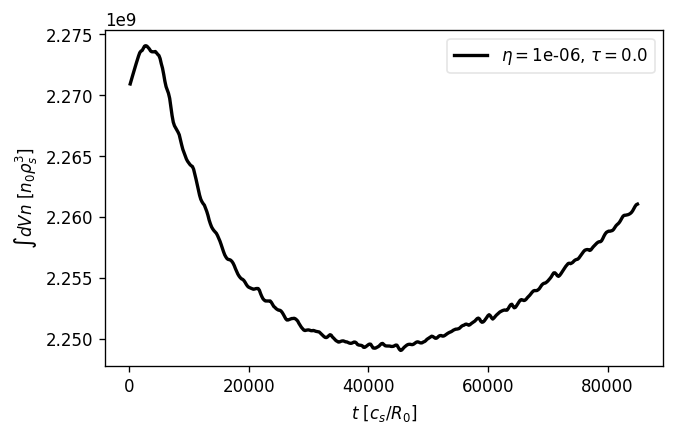

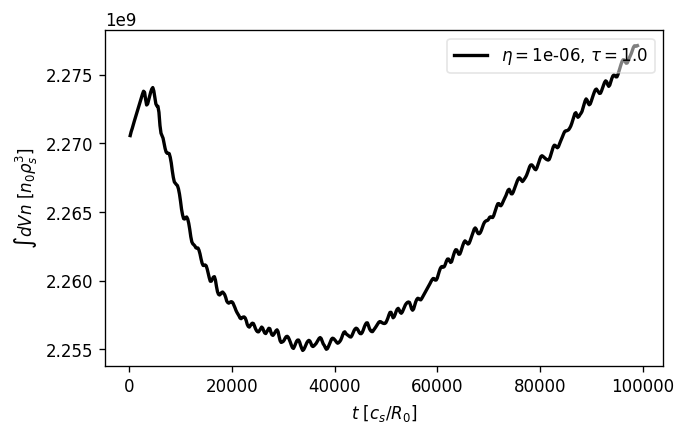

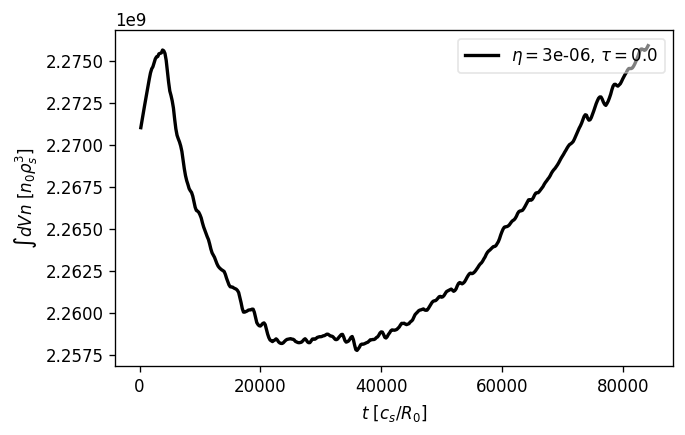

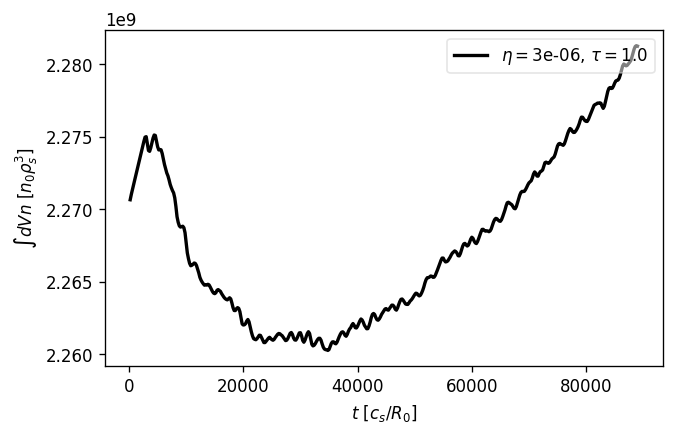

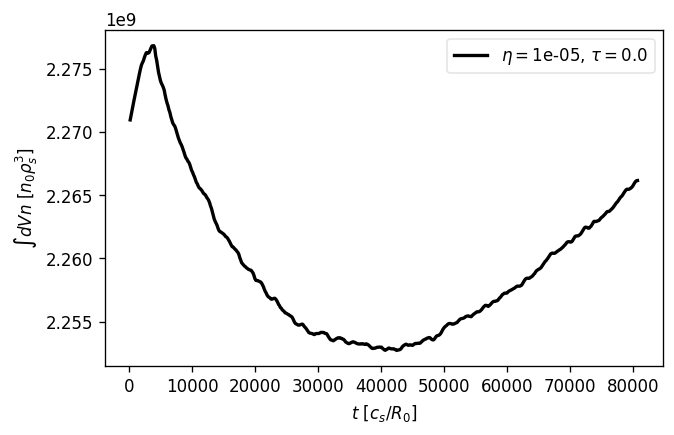

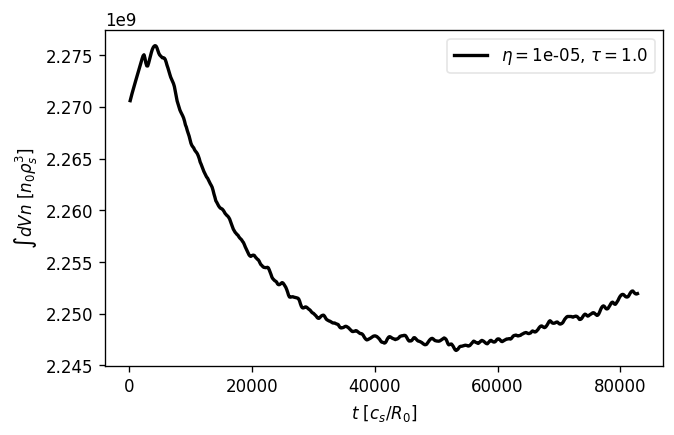

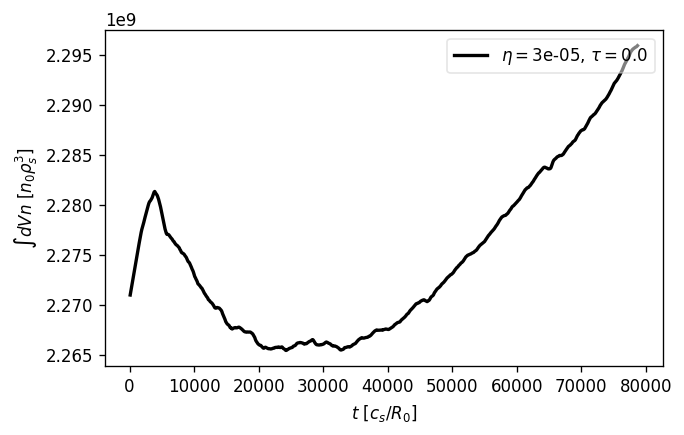

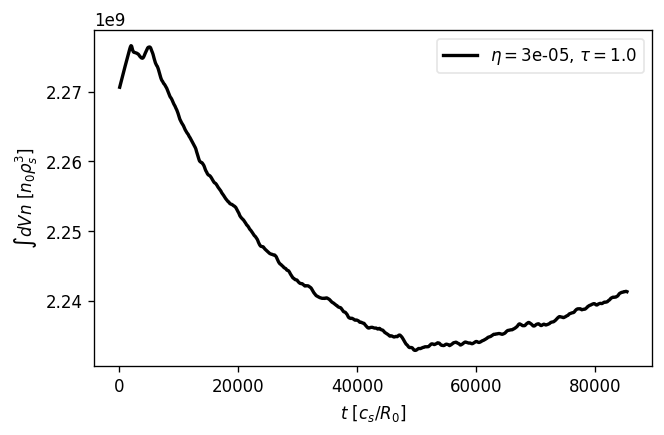

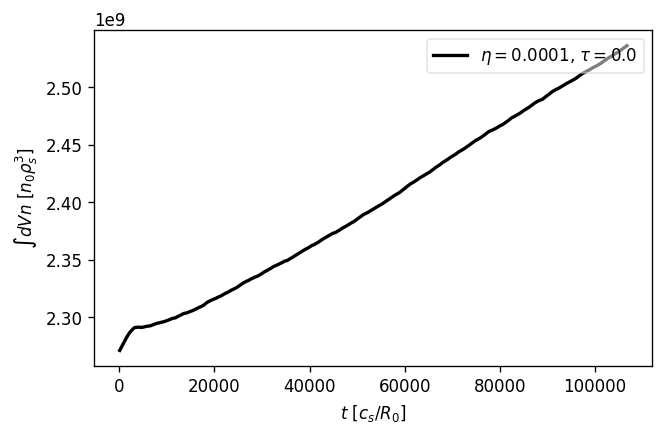

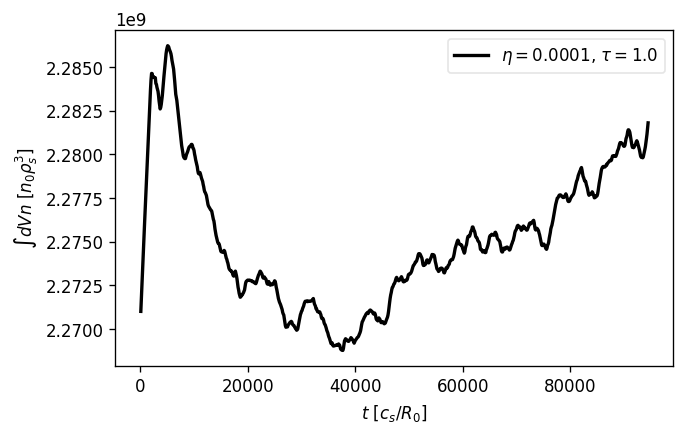

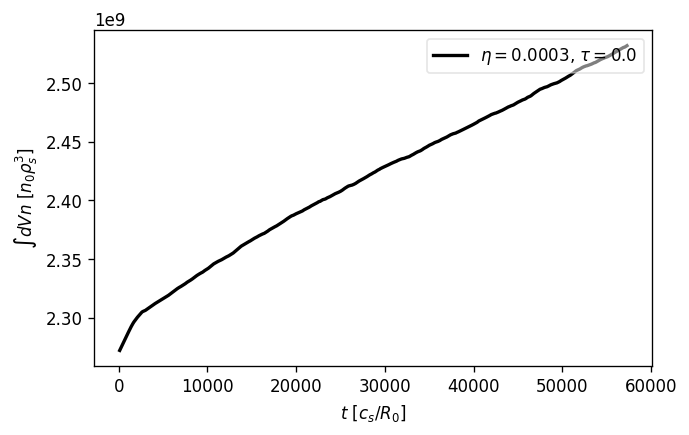

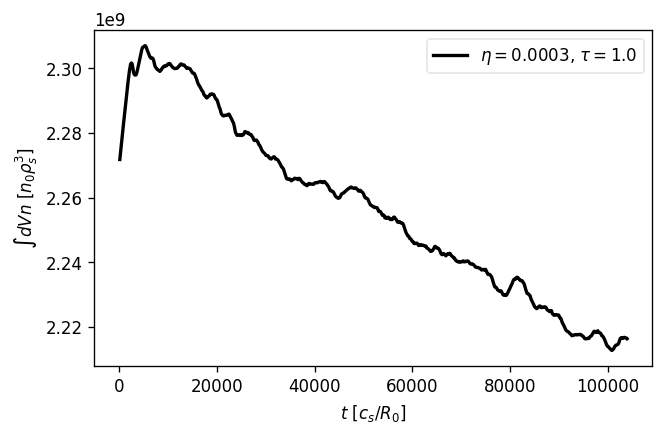

In [12]:
### PLOT OF TOTAL MASS CONTAINED WITHIN SEPARATRIX
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    time = np.asarray(da['time'][:])
    
#     print( pp["physical"])
#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
    timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])

    plt.plot(time[1:]*timescale,mass[1:], color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
            )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV n\ [n_0\rho_s^3]$")

    plt.show(   )

Average flux is 3.84e-04 pm 7.65e-05
Total average mass loss rate is 1887.8
Total mass gain by sources is 2096.9
particle confinement time = 1.96e+01


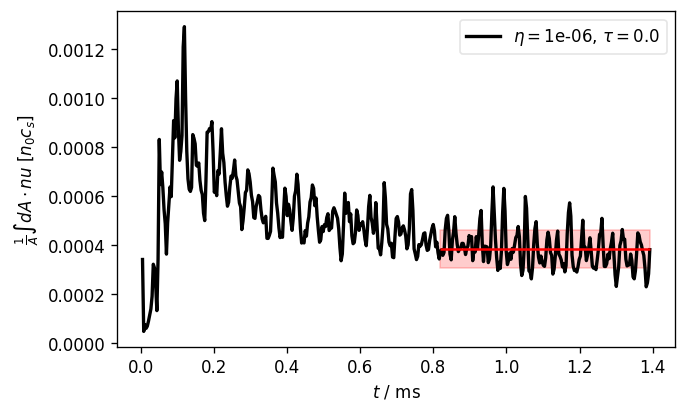

Average flux is 3.49e-04 pm 1.31e-04
Total average mass loss rate is 1717.3
Total mass gain by sources is 2096.9
particle confinement time = 2.16e+01


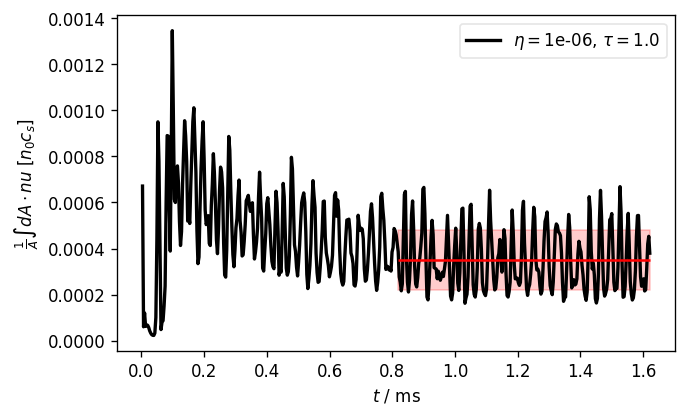

Average flux is 4.49e-04 pm 8.28e-05
Total average mass loss rate is 2209.2
Total mass gain by sources is 2516.2
particle confinement time = 2.21e+01


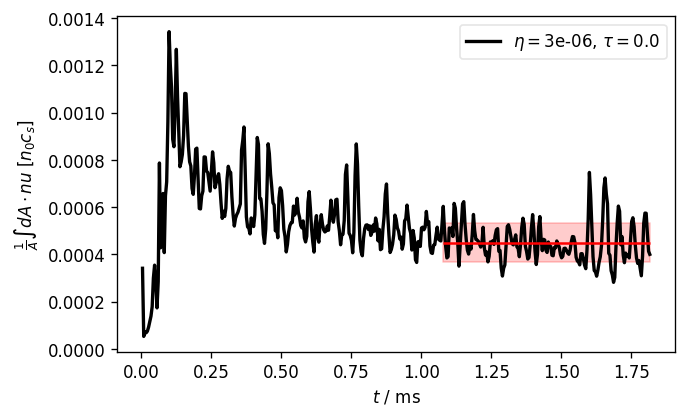

Average flux is 4.31e-04 pm 1.28e-04
Total average mass loss rate is 2120.3
Total mass gain by sources is 2516.2
particle confinement time = 2.31e+01


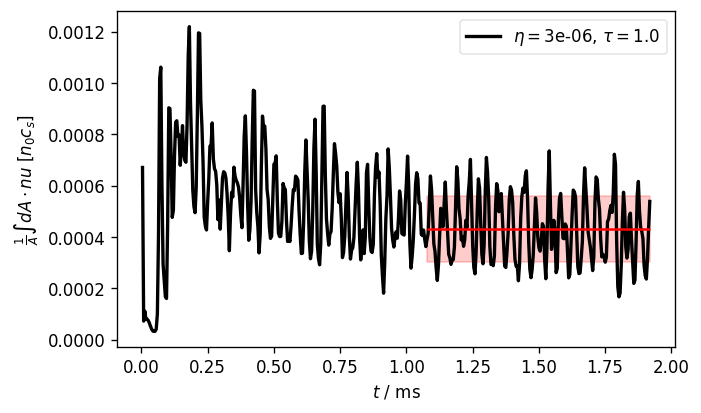

Average flux is 5.56e-04 pm 6.68e-05
Total average mass loss rate is 2732.3
Total mass gain by sources is 2935.6
particle confinement time = 2.41e+01


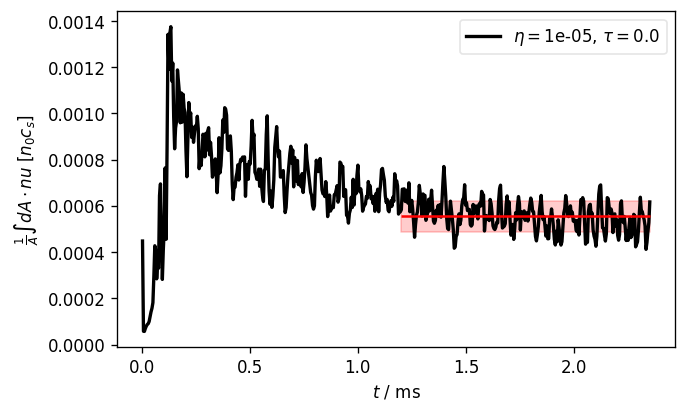

Average flux is 5.91e-04 pm 1.07e-04
Total average mass loss rate is 2905.7
Total mass gain by sources is 2935.6
particle confinement time = 2.25e+01


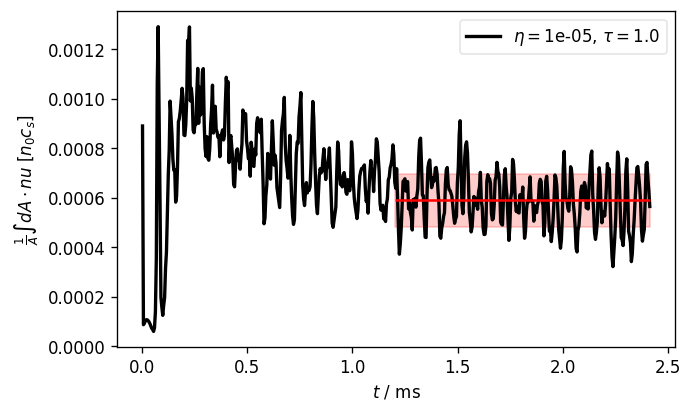

Average flux is 7.24e-04 pm 8.07e-05
Total average mass loss rate is 3562.0
Total mass gain by sources is 4193.7
particle confinement time = 2.46e+01


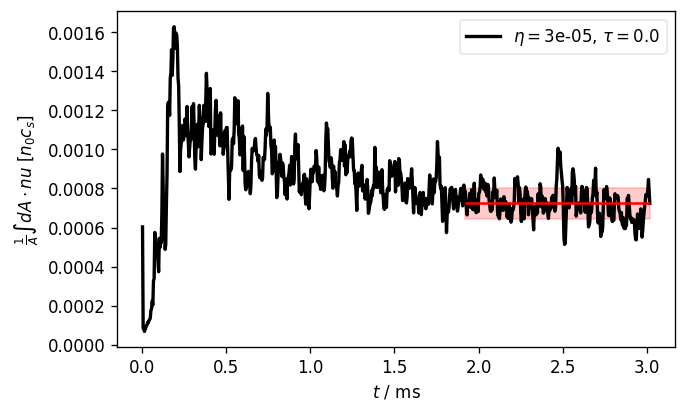

Average flux is 8.32e-04 pm 9.32e-05
Total average mass loss rate is 4089.9
Total mass gain by sources is 4193.7
particle confinement time = 2.10e+01


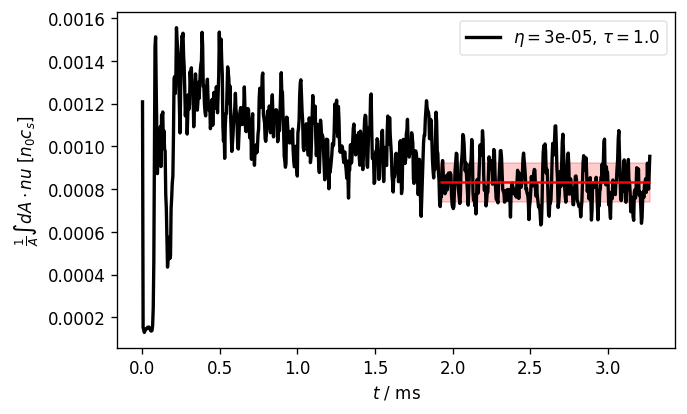

Average flux is 1.23e-03 pm 1.12e-04
Total average mass loss rate is 6029.5
Total mass gain by sources is 8387.4
particle confinement time = 2.08e+01


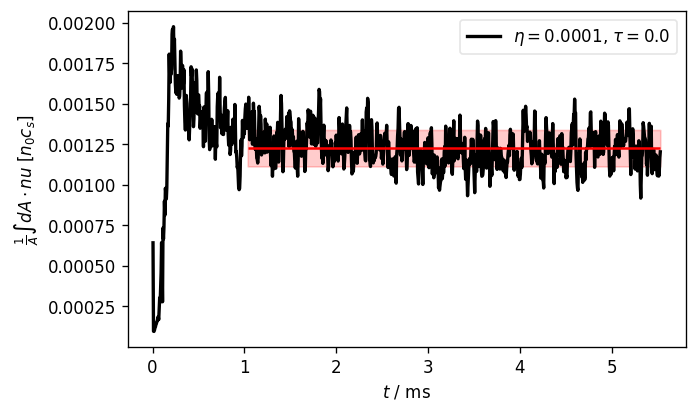

Average flux is 1.73e-03 pm 1.87e-04
Total average mass loss rate is 8521.4
Total mass gain by sources is 8387.4
particle confinement time = 1.38e+01


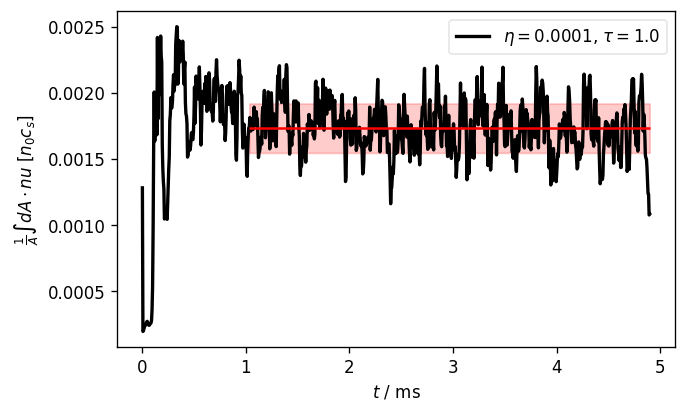

Average flux is 2.67e-03 pm 1.98e-04
Total average mass loss rate is 13156.3
Total mass gain by sources is 16774.8
particle confinement time = 1.27e+01


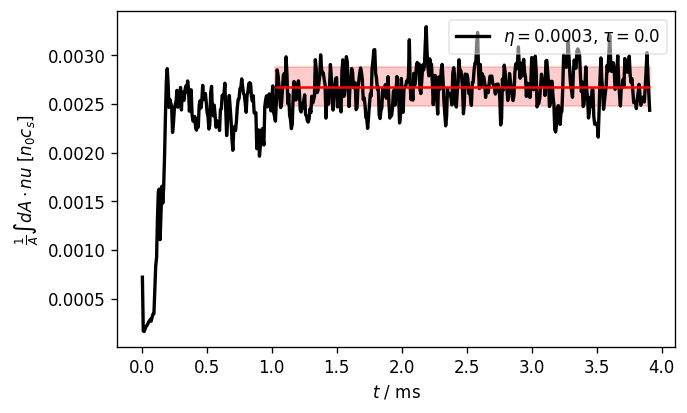

Average flux is 3.73e-03 pm 3.98e-04
Total average mass loss rate is 18340.3
Total mass gain by sources is 16774.8
particle confinement time = 8.36e+00


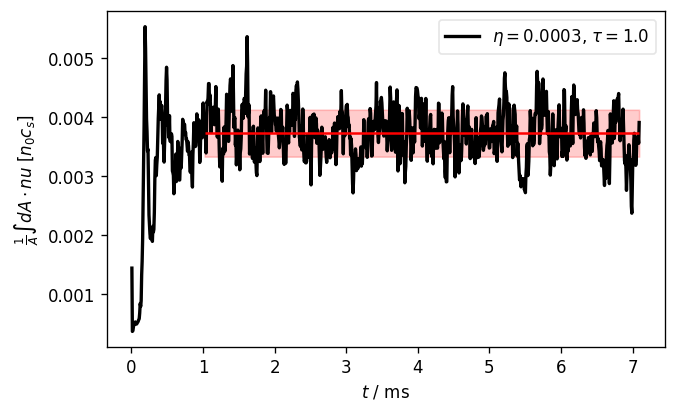

In [13]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')

    da = pp['file']

#     with open( "test-file.json","w") as f:
#         f.write(da.inputfile)
    
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne=np.asarray(da['jvneC_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneE_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvne = np.asarray(da["divjnepar_tt_ifs_lcfs"][:])/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_mass_flux_lcfs'] = average_jvne
    pp['physical']['average_mass_ifs'] = average_mass
    pp['physical']['sigma_mass_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_mass_ifs'] = sigma_mass
    ###################################
    source = np.asarray(da["sne_tt_ifs_lcfs"][:])/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print( f"Average flux is { average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne
    indices = range(min_idx,np.size(time))
    plt.plot(time[1:]*timescale,jvne[1:]/area, color='k', 
#     plt.plot(indices,jvne[min_idx:]/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
            )
    plt.hlines(average_jvne/area,
               time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)
#     plt.hlines(indices, time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ /\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'mass-flux.png',bbox_inches='tight')
    plt.show(   )


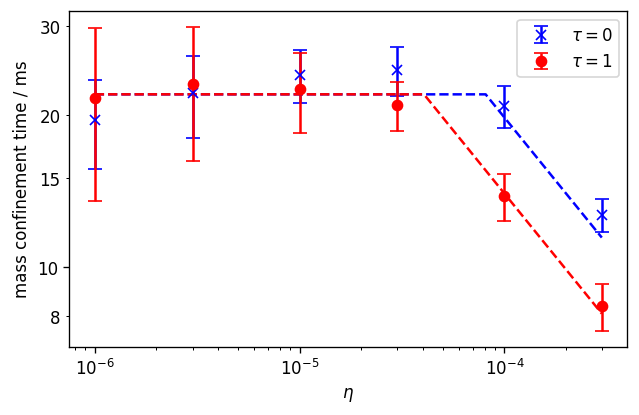

In [14]:
resistivities = {0: [], 1: []}
confinement_times = {0: [], 1: []}
confinement_errs = {0: [], 1: []}
models = {0: [], 1: []}
for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    confinement_times[phys['tau']].append(
        phys['average_mass_ifs']/phys['average_mass_flux_lcfs']*timescale)
 
    confinement_errs[phys['tau']].append(
        np.sqrt((phys['sigma_mass_ifs']/phys['average_mass_flux_lcfs'])**2 + 
                (phys['average_mass_ifs']/phys['average_mass_flux_lcfs']**2*phys['sigma_mass_flux_lcfs'])**2)*
                timescale)
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    if res > 2*4e-5: 
        models[0].append(
            np.sqrt(2)*0.0014*(1e-4*res)**(-0.5)
        )
    else:
        models[0].append(22)
    if res > 4e-5: 
        models[1].append(
            0.0014*(1e-4*res)**(-0.5)
        )
    else:
        models[1].append(22)
##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times[0],
             yerr=confinement_errs[0], marker='x', ls='',label=r'$\tau=0$',
            color = 'b',capsize=4)
ax.errorbar( resistivities[1], confinement_times[1],
             yerr=confinement_errs[1], marker='o', ls='',label=r'$\tau=1$',
            color = 'r',capsize=4)
ax.plot( lin_res, models[0], ls='--', color = 'b')
ax.plot( lin_res, models[1], ls='--', color = 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('mass confinement time / ms')
# Rewrite the y labels
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.set_yticks( [8, 15, 20,30], minor = True)

plt.legend()
plt.savefig('mass_confinement_time.png',bbox_inches='tight')
plt.show()

### Volume Integrated Mass conservation

In [15]:
# http://vrl.cs.brown.edu/color
colors =[ 
# "#256676", "#b4dbe7", "#1e39ae", "#aad46f", "#940393",
#  "#43e26d", "#d60724", "#3eeaef", "#0b5313", "#cd6ad8"] #change color 6,which is red
"#32964d", "#ad0599", "#39f27a", "#323d96", "#2fddce",
 "#0a4f4e", "#a1d832", "#8b6fed", "#38b5fc", "#752e4f"]

In [16]:
# to_plot = dict()
# {
#     "tau" : [], # taus
#     "res": {0:[],1:[]} # resistivities for taus
#     "fields" : [ # list of dicts
#     {
#         "color": 0,
#         "label" : r"$\partial_t n_e$",
#         "vals": {0:{res: [], ...},1:{...}}, # time series for tau = 0 and tau = 1 and various resistivities
#     }
#     ]
# }
def plot_relative( to_plot, ax, tau):  
    """Compute mean and error of several terms described in to_plot as a function of resistivity
    on given axis ax, for given tau
    """
    resistivities = np.array(sorted(to_plot["res"][tau]))
    size = resistivities.size
    mean=dict()
#     std = dict()
    for field in to_plot["fields"]:
        mean[field["label"]]=np.zeros(size)
#         std[field["name"]]=np.zeros(size)
        for i in np.arange(0,size,1):  
            min_idx = min_idx_dict[tau][resistivities[i]]
            mean[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].mean()
#             std[field["name"]][i] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = np.zeros(size)
    for field in to_plot["fields"]:
        error = error + mean[field["label"]]
#     print( "Error is ", error)
    summe = np.abs(error)
    for field in to_plot["fields"]:
        summe = summe + np.abs(mean[field["label"]])

    ax.plot( resistivities, np.abs(error)/summe,
            marker='x', ls='--',label="Error",  color = "r"
           )
    for field in to_plot["fields"]:
        ax.plot( resistivities, np.abs(mean[field["label"]])/summe,
    #                  yerr=delta_err[tau],capsize=4
            marker='x', ls='-',label=field["label"],  color = colors[field["color"]])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('relative magnitude')
    

In [17]:
def plot_series( to_plot, ax, tau, res):   
    """Plot several terms described in to_plot as a function of time on given axis
    for given tau and resistivity
    """
    mean=dict()
#     std = dict()
    min_idx = min_idx_dict[tau][res]
    for field in to_plot["fields"]:
        mean[field["label"]] = field["vals"][tau][res][min_idx:].mean()
#       std[field["name"]] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = np.zeros( len(to_plot["times"][tau][res]))
    for field in to_plot["fields"]:
        error = error + field["vals"][tau][res]
    mean_error = error[min_idx:].mean()
    std_error = error[min_idx:].std()
    print( "Mean error is ", mean_error, " std error is ", std_error)

    ax.plot( to_plot["times"][tau][res][1:], error[1:],
            ls='--',label="Error",  color = "r"
           )
    for field in to_plot["fields"]:
        ax.plot( to_plot["times"][tau][res][1:], field["vals"][tau][res][1:],
    #                  yerr=delta_err[tau],capsize=4
            ls='-',label=field["label"],
                color = colors[field["color"]])

    ax.hlines(mean_error, to_plot["times"][tau][res][min_idx],
              to_plot["times"][tau][res][-1], color='r')
    ax.fill_between( to_plot["times"][tau][res][min_idx:],
                    (mean_error-std_error), (mean_error+std_error),
                    color='red', alpha=0.2)
    ax.set_xlabel(r'$t$ / $\Omega_0^{-1}$')
    ax.set_ylabel(r'$T_i$')

In [18]:
def make_to_plot( to_plot):
    """Fill in values in the to_plot dictionary"""
    for pp in content :
        da = pp['file']
        time = np.asarray(da['time'][:])
        deltat = np.diff(np.append(time, 2*time[-1] -time[-2]))
        tau = pp["physical"]["tau"]
        res = pp["physical"]["resistivity"]
        to_plot["res"][tau].append(res)
        to_plot["times"][tau][res] = time
        for field in to_plot["fields"]:
            series = np.zeros(len(time))
            for (name,sign) in zip(field["names"],field["signs"]):
                if "idx" in field.keys():
                    series = series + np.asarray(da[name][:,field["idx"]])*sign
                else:
                    series = series + np.asarray(da[name][:])*sign
            if field["derive"]:
                series = np.diff(np.append(np.zeros(1),series, axis=0))/deltat
            else:
                series = series/deltat
            field["vals"][tau][res] = series

In [19]:
### THE TERMS IN THE MASS CONSERVATION
to_plot = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t n_e$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec j_E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\vec \nabla\cdot\vec j_C$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['jvneA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "color": 3,
#         "label" :  r"$\vec \nabla\cdot\vec j_A$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['divjnepar_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "color": 4,
#         "label" :  r"$\vec \nabla \cdot \vec j_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['lneperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 1,
#         "label" :  r"$\Delta_\perp$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['lneparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 9,
#         "label" :  r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sne_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 7,
        "label" :  r"$S_{n_e}$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}
make_to_plot(to_plot)


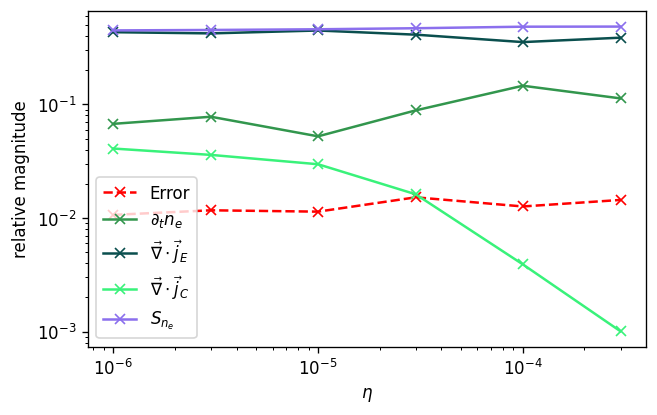

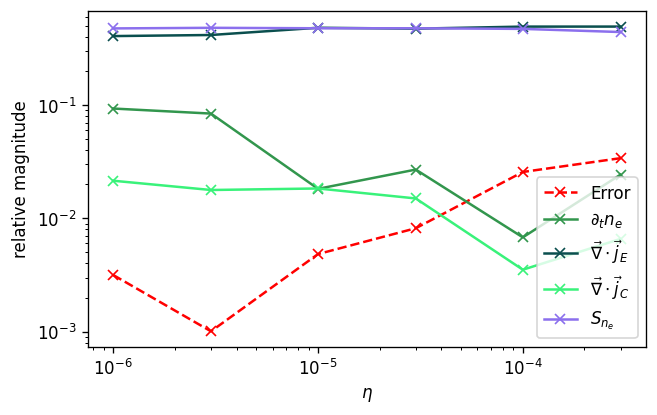

In [20]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

Mean error is  457.3494729854756  std error is  137.5377956160467


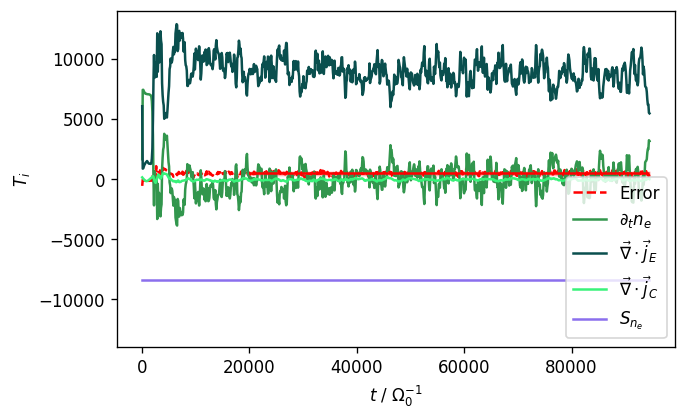

In [21]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot,ax,tau,res)
#     ax.set_yscale("linear")
# get y-axis limits of the plot
low, high = ax.get_ylim()
# find the new limits
bound = max(abs(low), abs(high))
# set new limits
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

## Energy conservation

Average flux is 1.60e-04 pm 3.66e-05
Total average energy loss rate is  788.8
Total energy gain by sources is 6722.1
Energy confinement time = 8.08e+01


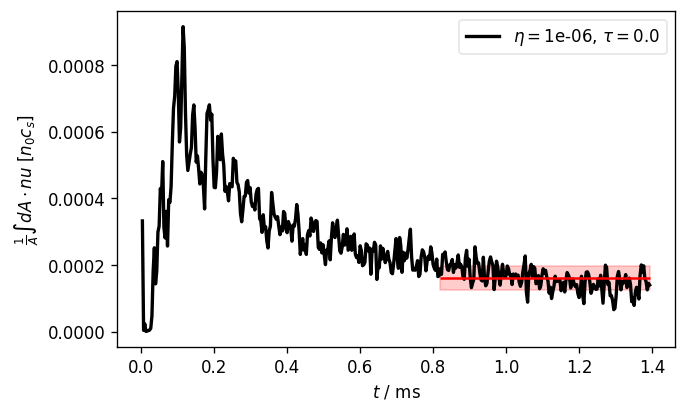

Average flux is 2.49e-04 pm 8.60e-05
Total average energy loss rate is 1222.7
Total energy gain by sources is 13463.4
Energy confinement time = 1.05e+02


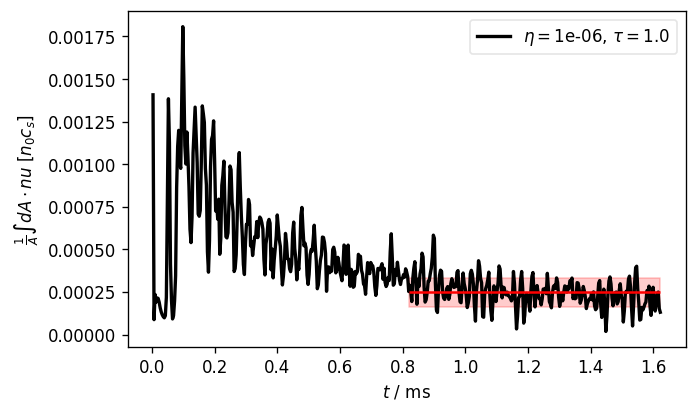

Average flux is 2.13e-04 pm 3.39e-05
Total average energy loss rate is 1048.8
Total energy gain by sources is 8118.5
Energy confinement time = 8.08e+01


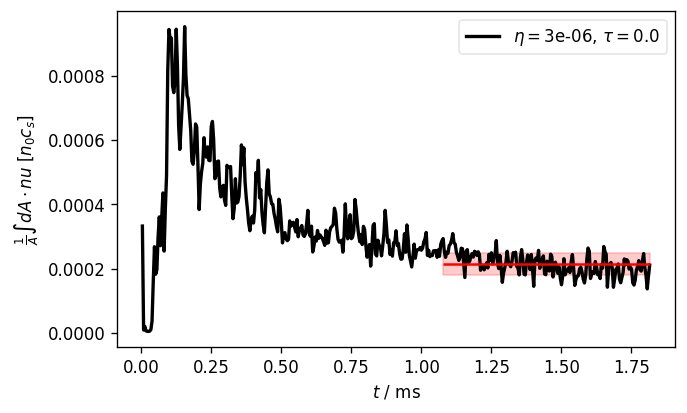

Average flux is 3.84e-04 pm 1.01e-04
Total average energy loss rate is 1890.3
Total energy gain by sources is 16237.1
Energy confinement time = 8.99e+01


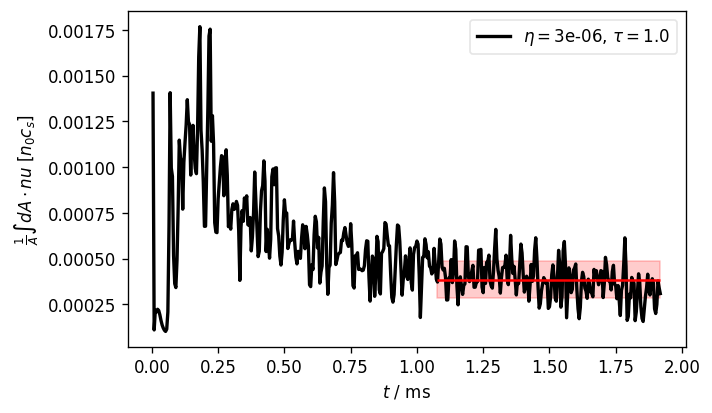

Average flux is 3.13e-04 pm 4.67e-05
Total average energy loss rate is 1538.0
Total energy gain by sources is 9473.3
Energy confinement time = 7.38e+01


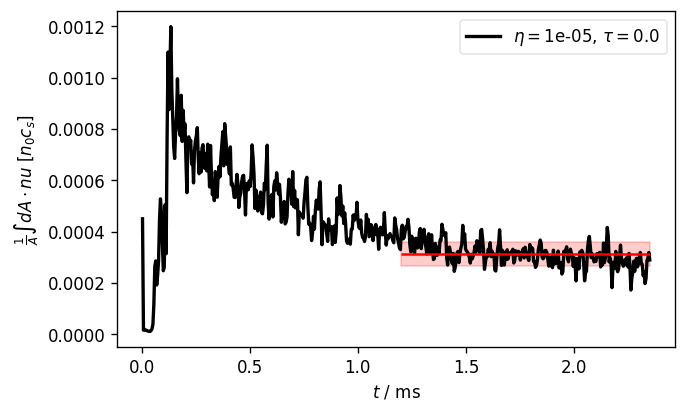

Average flux is 6.91e-04 pm 1.44e-04
Total average energy loss rate is 3398.0
Total energy gain by sources is 18885.4
Energy confinement time = 6.62e+01


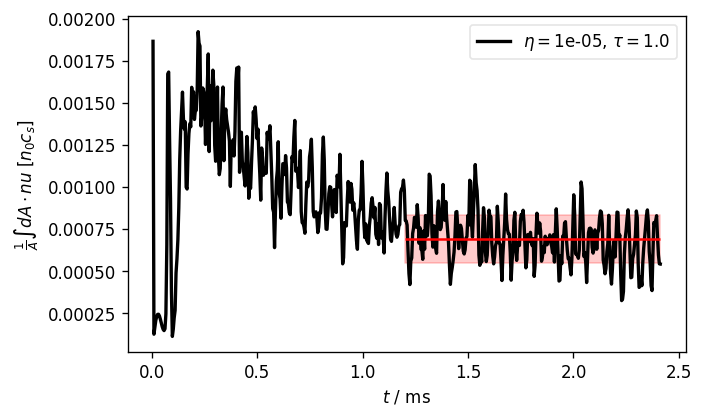

Average flux is 4.33e-04 pm 5.89e-05
Total average energy loss rate is 2129.9
Total energy gain by sources is 13698.1
Energy confinement time = 7.19e+01


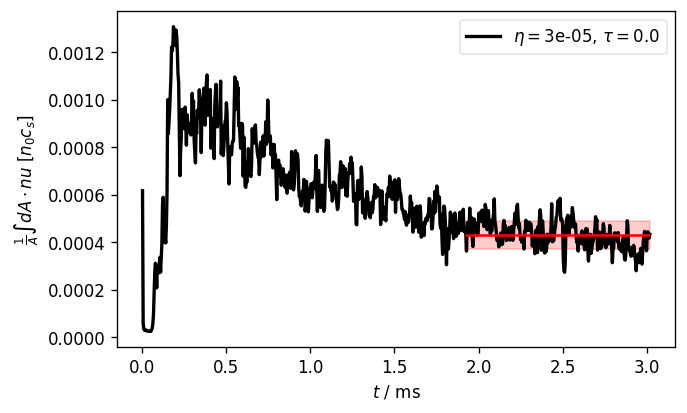

Average flux is 1.07e-03 pm 1.53e-04
Total average energy loss rate is 5254.8
Total energy gain by sources is 27153.9
Energy confinement time = 5.63e+01


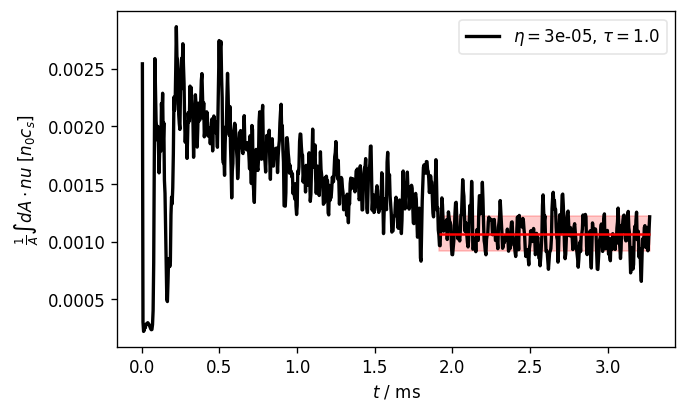

Average flux is 1.04e-03 pm 1.11e-04
Total average energy loss rate is 5108.9
Total energy gain by sources is 27629.8
Energy confinement time = 4.40e+01


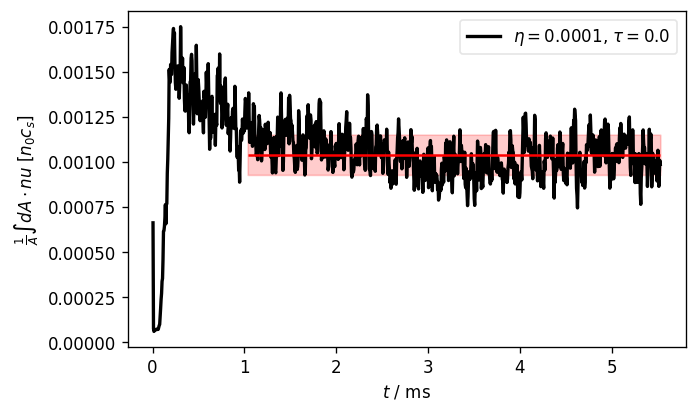

Average flux is 3.31e-03 pm 4.03e-04
Total average energy loss rate is 16277.8
Total energy gain by sources is 53547.0
Energy confinement time = 2.46e+01


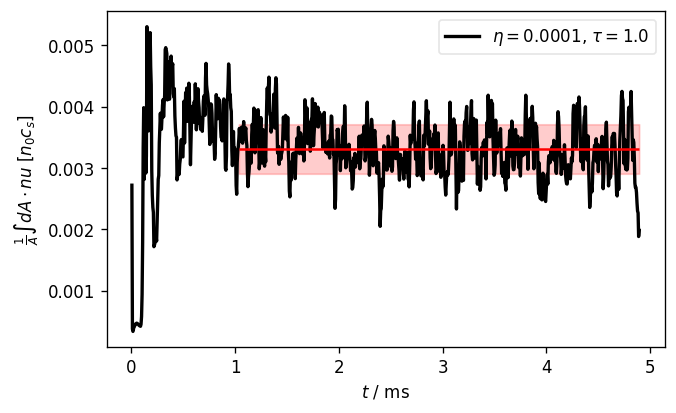

Average flux is 3.36e-03 pm 2.87e-04
Total average energy loss rate is 16517.1
Total energy gain by sources is 54135.7
Energy confinement time = 1.77e+01


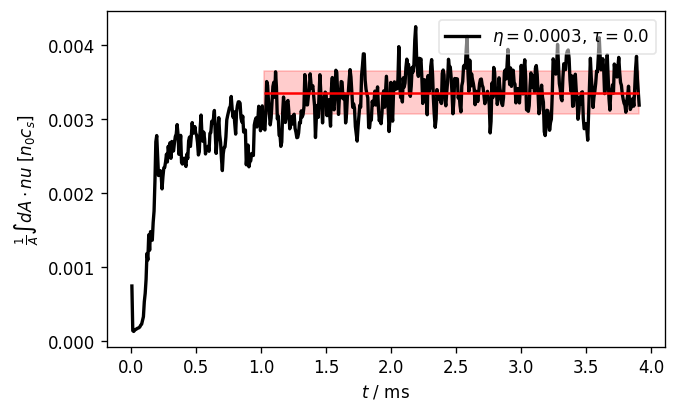

Average flux is 1.00e-02 pm 1.17e-03
Total average energy loss rate is 49403.8
Total energy gain by sources is 103869.1
Energy confinement time = 1.02e+01


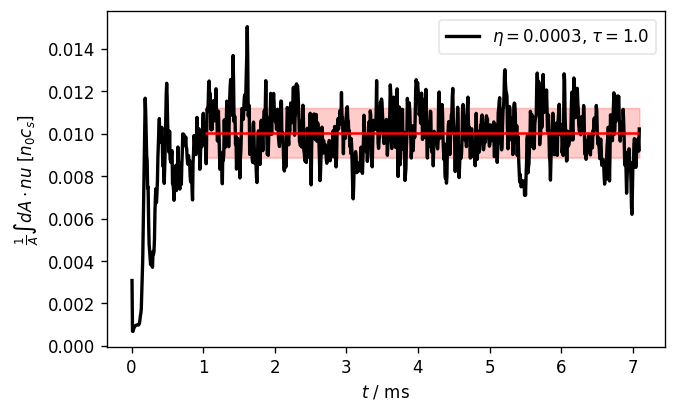

In [22]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    
    da = pp['file']
 
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)

    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]

#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['ue2_ifs_lcfs'][:])
    mass+=np.asarray(da['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(da['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(da['neue2_ifs_lcfs'][:])
    mass+=np.asarray(da['niui2_ifs_lcfs'][:])
    mass+=np.asarray(da['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne = da.variables['jvee_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jvei_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveea_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveia_tt_ifs_lcfs'][:]/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_energy_flux_lcfs'] = average_jvne
    pp['physical']['average_energy_ifs'] = average_mass
    pp['physical']['sigma_energy_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_energy_ifs'] = sigma_mass
    ###################################
    source =da.variables['see_tt_ifs_lcfs'][:]/deltat
    source+=da.variables['sei_tt_ifs_lcfs'][:]/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print( f"Average flux is { average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average energy loss rate is {average_jvne:6.1f}")
    print( f"Total energy gain by sources is {average_source:6.1f}" )
    print( f"Energy confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne

    plt.plot(time[1:]*timescale,jvne[1:]/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}')
    plt.hlines(average_jvne/area, time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ /\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'energy-flux.png',bbox_inches='tight')
    plt.show(   )


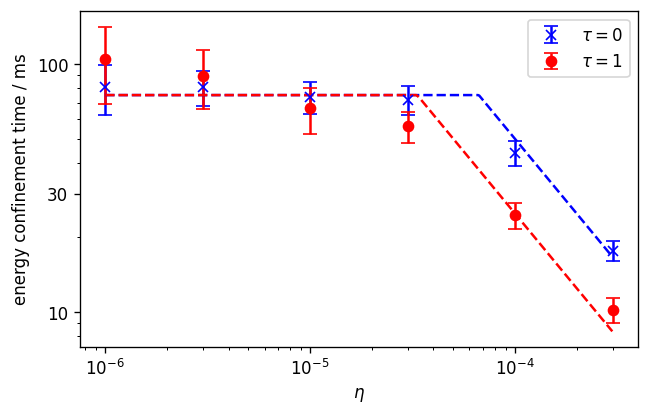

In [23]:
resistivities = {0: [], 1: []}
confinement_times = {0: [], 1: []}
confinement_errs = {0: [], 1: []}

for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    confinement_times[phys['tau']].append(
        phys['average_energy_ifs']/phys['average_energy_flux_lcfs']*timescale)
 
    confinement_errs[phys['tau']].append(
        np.sqrt((phys['sigma_energy_ifs']/phys['average_energy_flux_lcfs'])**2 + 
                (phys['average_energy_ifs']/phys['average_energy_flux_lcfs']**2*phys['sigma_energy_flux_lcfs'])**2)*
                timescale)
models = {0: [], 1: []}
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    if res > 2*3.3e-5: 
        models[0].append(
            2*2.5e-7*(1e-4*res)**(-1)
        )
    else:
        models[0].append(75)
    if res > 3.3e-5: 
        models[1].append(
            2.5e-7*(1e-4*res)**(-1)
        )
    else:
        models[1].append(75)

##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times[0],
             yerr=confinement_errs[0], marker='x', ls='',label=r'$\tau=0$',
            color = 'b',capsize=4)
ax.errorbar( resistivities[1], confinement_times[1],
             yerr=confinement_errs[1], marker='o', ls='',label=r'$\tau=1$',
            color = 'r',capsize=4)
ax.plot( lin_res, models[0], ls='--', color = 'b')
ax.plot( lin_res, models[1], ls='--', color = 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('energy confinement time / ms')
# Rewrite the y labels
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.0f}'))
# ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.set_yticks( [10,30,100])

plt.legend()
plt.savefig('energy_confinement_time.png',bbox_inches='tight')
plt.show()

Let's be careful with too general conclusions about the two regimes. The equations are fairly basic with isothermal assumption. There could still be hidden systematic numerical issues (e.g. turbulence in low resistivity does not reach core region?)

In [24]:
### THE TERMS IN THE ENERGY CONSERVATION
to_plot_energy = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ["ue2_ifs_lcfs","nelnne_ifs_lcfs","nilnni_ifs_lcfs",
                   "neue2_ifs_lcfs","niui2_ifs_lcfs","aperp2_ifs_lcfs"],
        "derive" : True, "signs" : [+1,1,1,1,1,1],
        "color": 0,
        "label" : r"$\partial_t E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvee_tt_ifs_lcfs','jvei_tt_ifs_lcfs','jveea_tt_ifs_lcfs','jveia_tt_ifs_lcfs'],
        "derive" : False, "signs" : [+1,1,1,1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec j_E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeperp_tt_ifs_lcfs','leiperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 1,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeparallel_tt_ifs_lcfs','leiparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['see_tt_ifs_lcfs','sei_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 7,
        "label" :  r"$S_{E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['resistivity_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 8,
        "label" :  r"$R$",
        "vals": {0:dict(),1:dict()},
    }
    ]
}
make_to_plot(to_plot_energy)


Mean error is  -1365.5110716166546  std error is  646.3569904894309


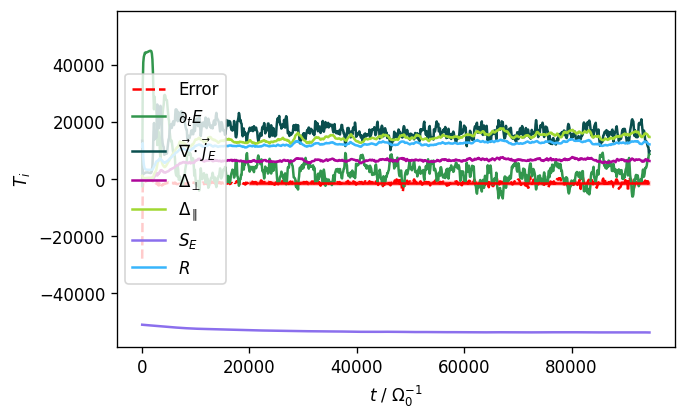

In [25]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_energy,ax,tau,res)
low, high = ax.get_ylim()
bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

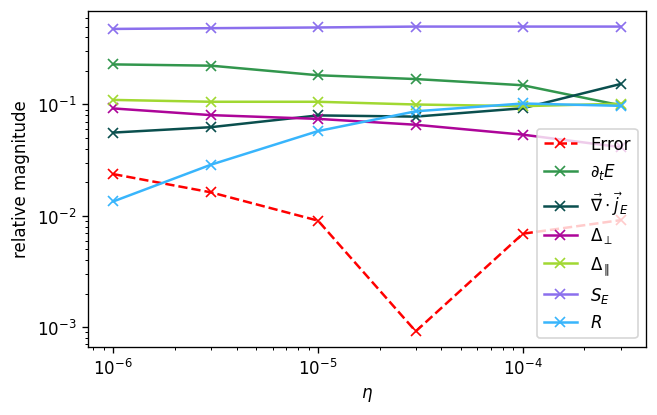

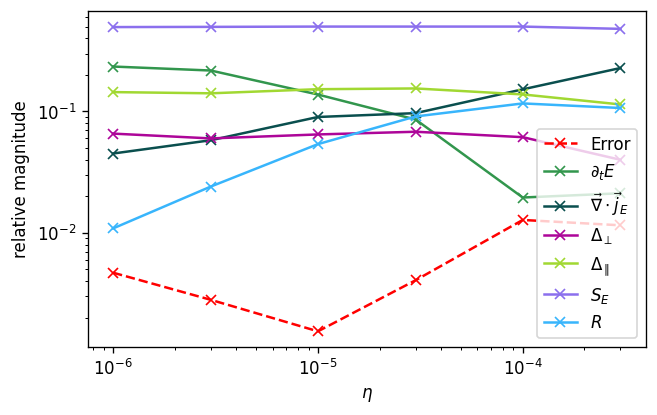

In [26]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_energy,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

### Average FSA Mass conservation 

Resistivity = 1e-06
Average diff =  7.581830159731254e-07
Average std  =  1.2351615511078421e-05
Resistivity = 1e-06
Average diff =  7.441233085376719e-07
Average std  =  6.096859695402995e-06
Resistivity = 3e-06
Average diff =  -1.0937601976569085e-06
Average std  =  1.3155219840355359e-05
Resistivity = 3e-06
Average diff =  3.444994484571084e-07
Average std  =  6.671361775733707e-06
Resistivity = 1e-05
Average diff =  -1.0077055171892544e-06
Average std  =  1.5600864337756163e-05
Resistivity = 1e-05
Average diff =  8.516359475791302e-07
Average std  =  7.698987521798045e-06
Resistivity = 3e-05
Average diff =  -2.0451504394536148e-06
Average std  =  1.8563047743271235e-05
Resistivity = 3e-05
Average diff =  9.336839089712721e-07
Average std  =  9.497977863968593e-06
Resistivity = 0.0001
Average diff =  -1.2129830947451975e-06
Average std  =  1.4463373562993187e-05
Resistivity = 0.0001
Average diff =  1.5214224493964048e-06
Average std  =  8.166906110021797e-06
Resistivity = 0.0003
Ave

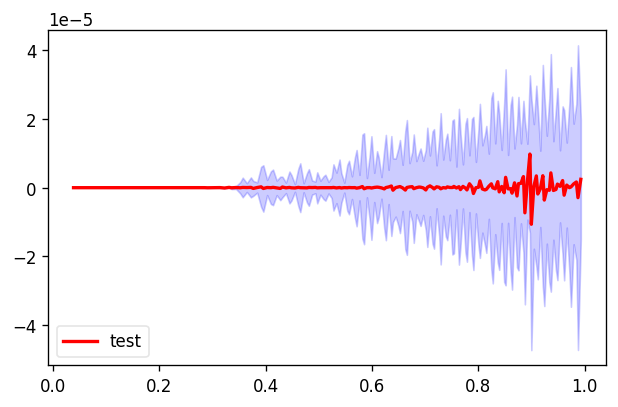

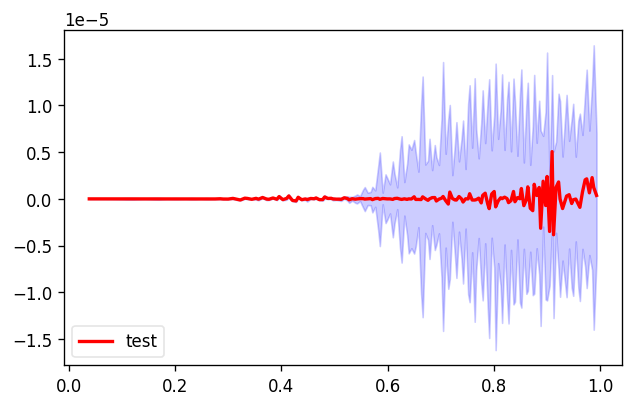

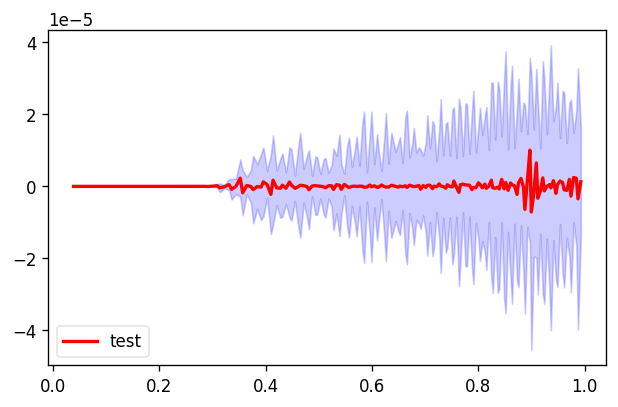

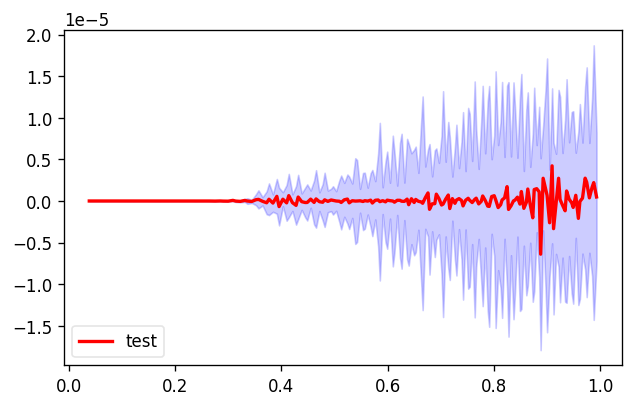

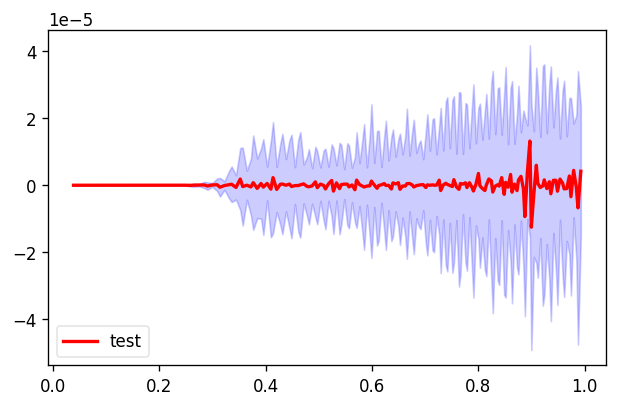

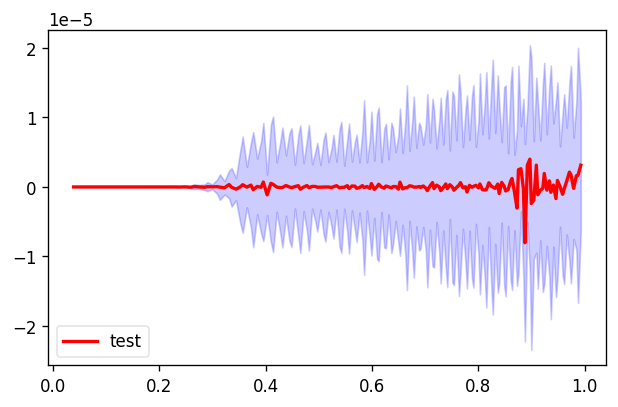

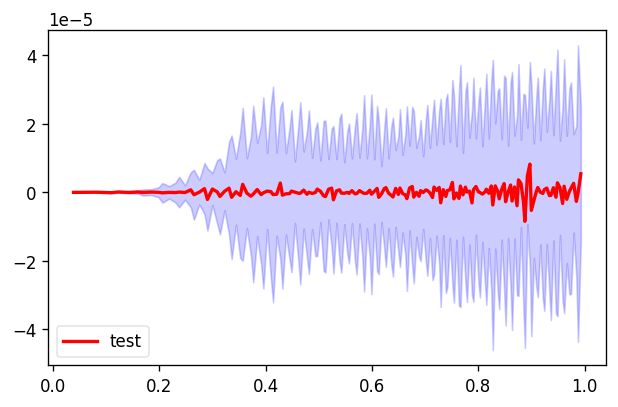

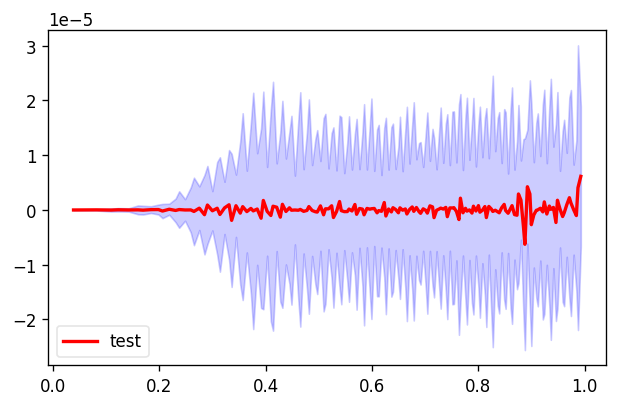

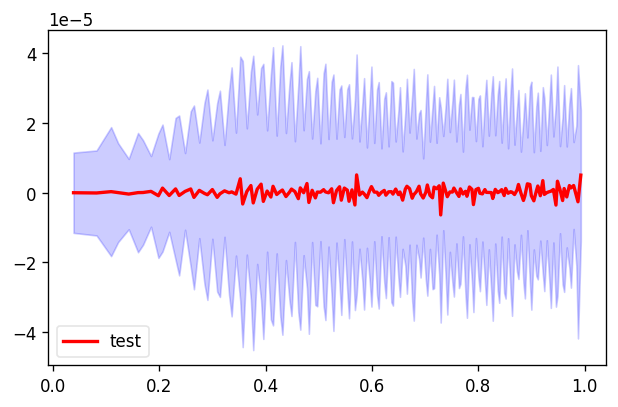

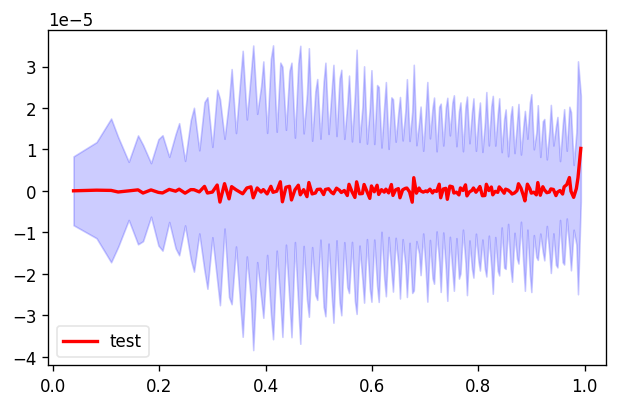

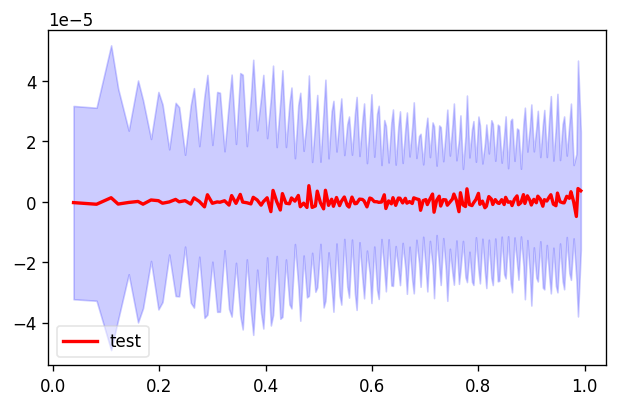

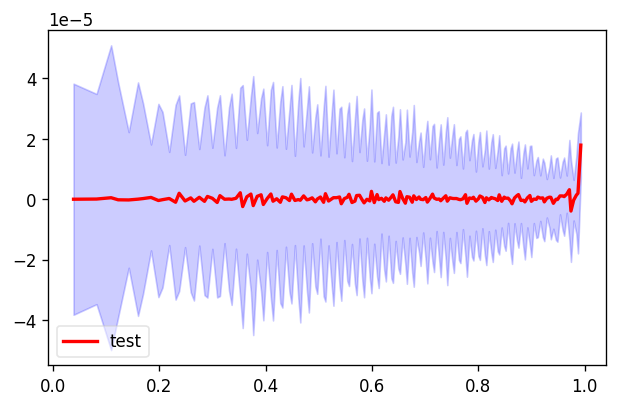

In [27]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    mass =np.asarray(da.variables['electrons_fsa'][:,:])
    time = np.asarray(da.variables['time'][:])
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(pp['rho']))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(da.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(da.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(da.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(da.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(da.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(da.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])

    plt.plot( pp['rho_t'][0:167], average_diff[0:167], ls = '-', color='r', lw = 2, label = 'test')
    plt.fill_between( pp['rho_t'][0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()

### Local Mass conservation on LCFS

Resistivity = 1e-06
Average diff =  0.00041320974370535424
Average std  =  0.0067316304535377375
Resistivity = 1e-06
Average diff =  0.000405547203153034
Average std  =  0.0033227885339946334
Resistivity = 3e-06
Average diff =  -0.0005960993077230167
Average std  =  0.007169594812993675
Resistivity = 3e-06
Average diff =  0.00018775219940912432
Average std  =  0.0036358921677748825
Resistivity = 1e-05
Average diff =  -0.0005491995068681432
Average std  =  0.00850247106407711
Resistivity = 1e-05
Average diff =  0.0004641415914306264
Average std  =  0.004195948199379931
Resistivity = 3e-05
Average diff =  -0.0011146069895022212
Average std  =  0.010116861020082822
Resistivity = 3e-05
Average diff =  0.0005088577303893457
Average std  =  0.005176397935862885
Resistivity = 0.0001
Average diff =  -0.0006610757866361277
Average std  =  0.007882538591831295
Resistivity = 0.0001
Average diff =  0.0008291752349210441
Average std  =  0.004450963829961872
Resistivity = 0.0003
Average diff =  0.00

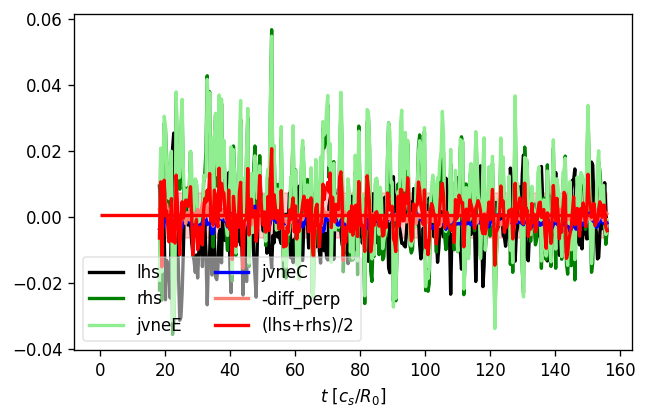

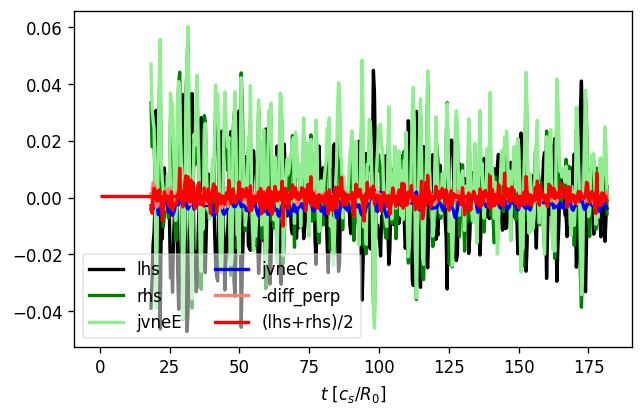

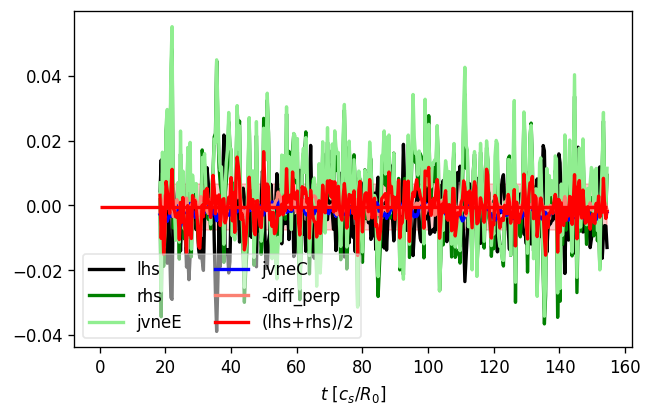

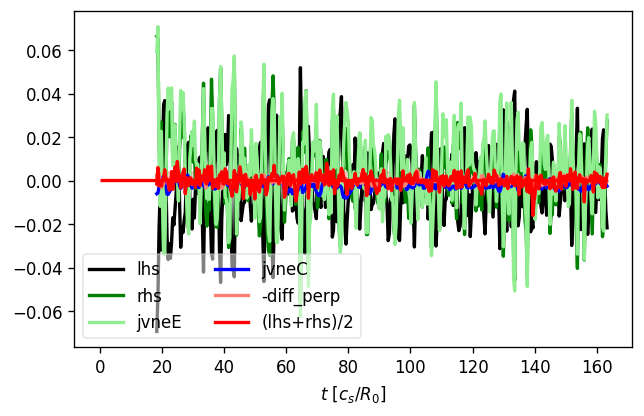

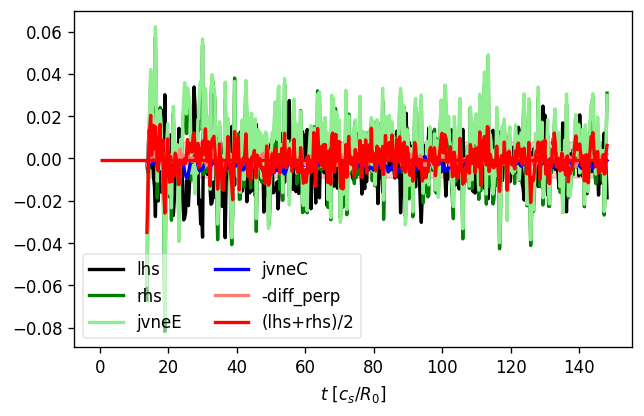

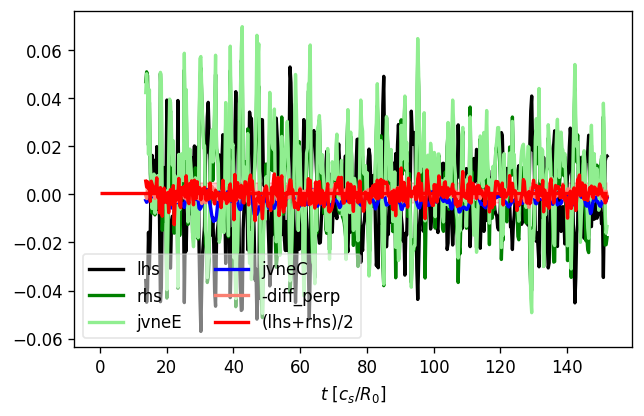

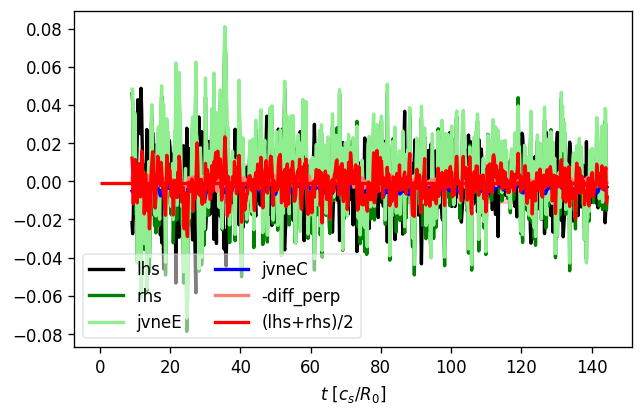

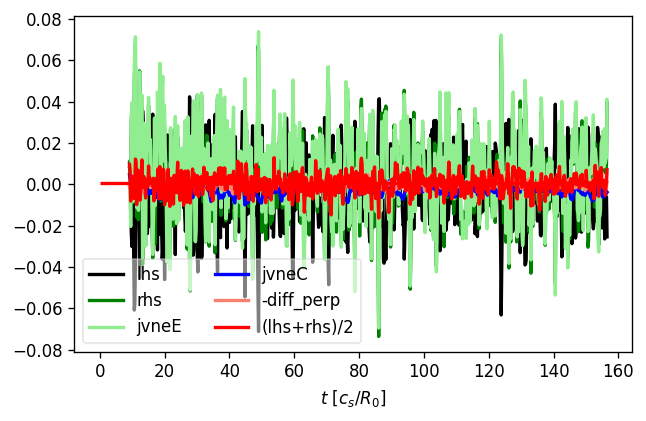

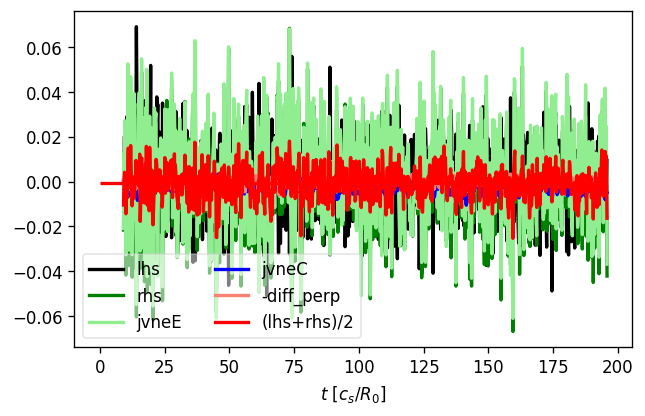

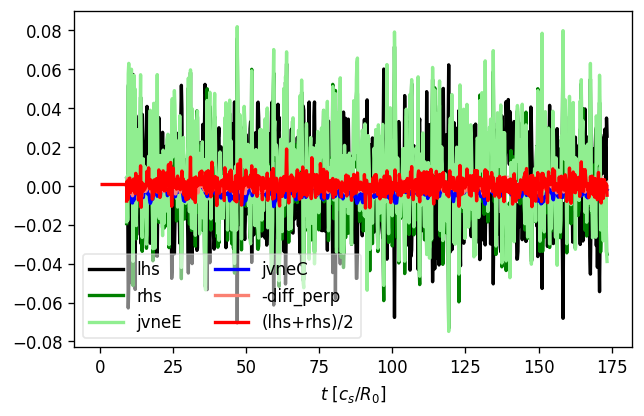

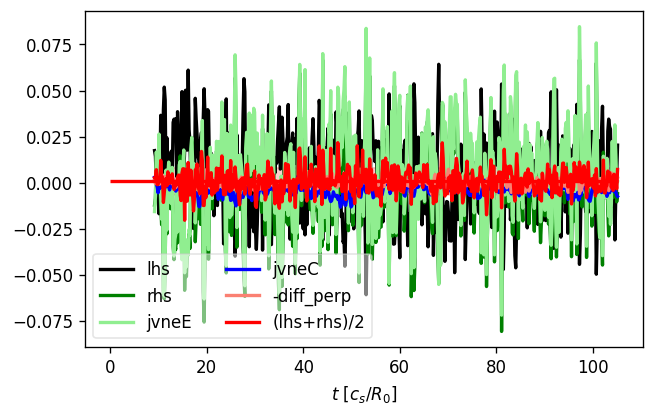

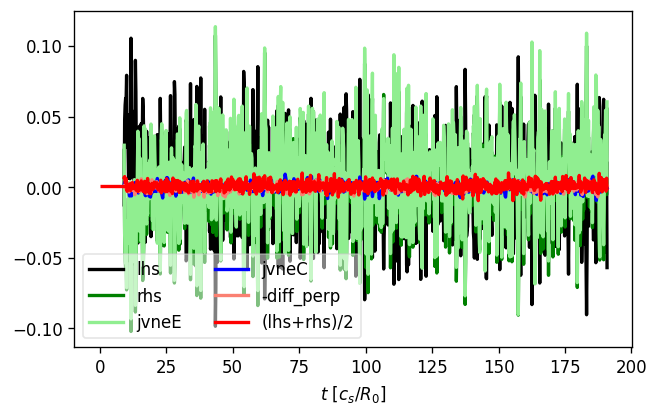

In [28]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    mass =np.asarray(da.variables['electrons_fsa'][:,:])

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    time = np.asarray(da.variables['time'][:])*timescale
    timett = np.append(2*time[-1] -time[-2], time ) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(pp['rho']))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(da.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(da.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(da.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(da.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(da.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(da.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    min_idx = 50
    plt.plot(time[min_idx:],deltamass[min_idx:,idx], color='k', marker='',
              ls='-',lw=2, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g',
              ls='-', lw = 2,  label="rhs")
    plt.plot(time[min_idx:],jvneE[min_idx:,idx], color='lightgreen',
              ls='-', lw = 2, label="jvneE")
    plt.plot(time[min_idx:],jvneC[min_idx:,idx], color='blue',
              ls='-', lw = 2, label="jvneC")
    plt.plot(time[min_idx:],-diff_perp[min_idx:,idx], color='salmon',
              ls='-', lw = 2,  label="-diff_perp")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r',
              ls='-', lw = 2,  label="(lhs+rhs)/2")
    plt.hlines(average_diff[idx], time[0], time[-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    plt.xlabel(r"$t\ [c_s/R_0]$")

### Density profile

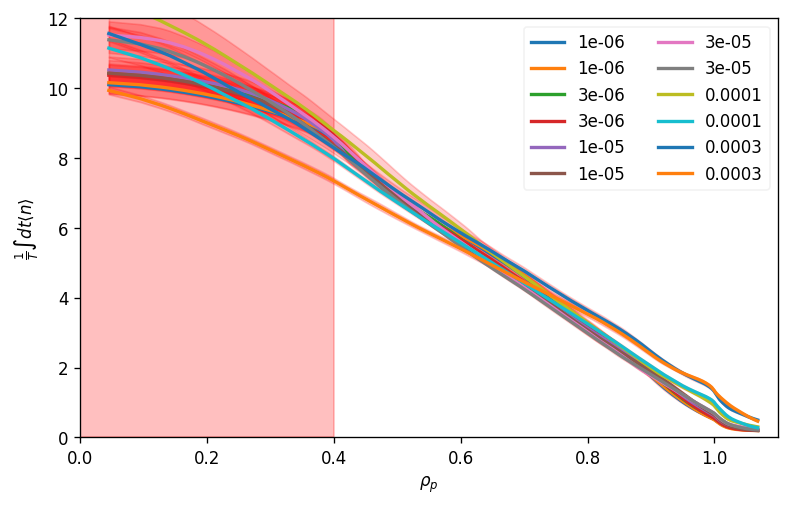

In [29]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
for pp in content :
    da = pp['file']

    time = np.asarray(da.variables['time'][:])
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    density =da.variables['electrons_fsa'][:]
    source = da.variables['sne_tt_fsa'][:]

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
#     print(f'Resistivity = {pp["physical"]["resistivity"]}')
#     print( "Dataset length ", len(time))
#     print( "Average region ", time[min_idx]*timescale, time[-1]*timescale)
    avg_density=density[min_idx:-1].mean(axis=0)
    std_density=density[min_idx:-1].std(axis=0)
    avg_source = source.mean(axis=0)
    plt.plot( pp['rho_p'], avg_density, ls='-', lw=2, label=f'{pp["physical"]["resistivity"]}')
    # plt.plot( pp['rho_t'], density[-1,:],color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( pp['rho_t'], avg_source*1000,color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( pp['rho_t'],   -psi_p*3+1, ls='--', color = 'k')
#     plt.plot( pp['rho_p'],   -psi_p/2+1, ls='--', color = 'k')
    plt.fill_between( pp['rho_p'], (avg_density-std_density), 
                      (avg_density+std_density), color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)
    da.close()
ax.axvspan(0, 0.4, alpha=0.25, color='red')

plt.xlabel(r"$\rho_p$")
# plt.xlabel(r"$\sqrt{\psi_p/\psi_{O}}$")

plt.ylabel(r"$\frac{1}{T}\int dt \langle n\rangle$")
plt.xlim(0.0,1.1)
plt.ylim(0,12)
plt.show(  )

### Vorticity accuracy on LCFS

In [30]:
### THE TERMS IN THE VORTICITY CONSERVATION
# idx=167 #=lcfs
idx = 167
to_plot_vorticity = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
#         "names" : ['oexbe_fsa'], # bad for tau = 1
        "names" : ['oexbe_fsa','odiae_fsa'],
#     vorticity =np.asarray(da['oexbe_fsa'][:,:])
    # vorticity+=da['odiae_fsa'][:,:]
    # vorticity/=da['electrons_fsa'][:,:]
        "idx":idx, "derive" : True,"signs" : [+1,1],
        "color": 0,
        "label" : r"$\partial_t (\Omega_E + \Omega_D)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvoexbi_tt_ifs'],
        "names" : ['jvoexbe_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec j_\Omega,E$",
        "vals": {0:dict(),1:dict()},
    },    
    {
#         "names" : ['jvoexbeUD_tt_ifs'], # bad for tau = 1
#         "names" : ['jvoexbiUD_tt_ifs'], # also quite bad
        "names" : ['jvodiaeUE_tt_ifs'],
#         "names" : ['jvodiaiUE_tt_ifs'], # above 10%
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\vec \nabla\cdot\vec j_\Omega,D$",
        "vals": {0:dict(),1:dict()},
    },  
    {
        "names" : ['jvoapar_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 8,
        "label" : r"$\vec \nabla\cdot\vec j_{\Omega,A}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvoexbApar_tt_ifs'],
        "names" : ['jvodiaApar_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 9,
        "label" : r"$\vec \nabla\cdot\vec j_{\Omega,D,A}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['loexbe_tt_fsa'],"idx":idx, "derive" : False, "sign" : -1,
#         "color": 1,
#         "label" :  r"$\Lambda$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['socurve_tt_fsa','socurvi_tt_fsa','socurvkappae_tt_fsa','socurvkappai_tt_fsa'],
#     # force2 = -da["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
        "idx":idx, "derive" : False, "signs" : [-1,-1,-1,-1],
        "color": 6,
        "label" :  r"$Force$",
        "vals": {0:dict(),1:dict()},
    }
#     {
#         "names" : [''], "derive" : False, "sign" : -1,
#     # source = da["sosne_tt_fsa"][:,:]/deltat[:,None]
#     # source+= da["sospi_tt_fsa"][:,:]/deltat[:,None]
#         "color": 7,
#         "label" :  r"$S_{E}$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}
make_to_plot(to_plot_vorticity)


Mean error is  -9.537290014211534e-07  std error is  1.1701208756115434e-06


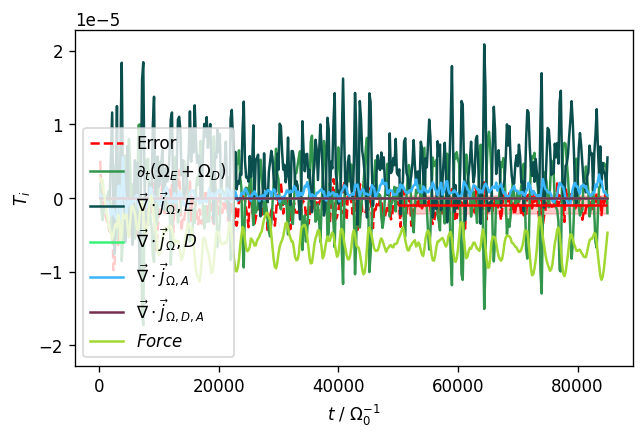

In [31]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-6
plot_series(to_plot_vorticity,ax,tau,res)
low, high = ax.get_ylim()
bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

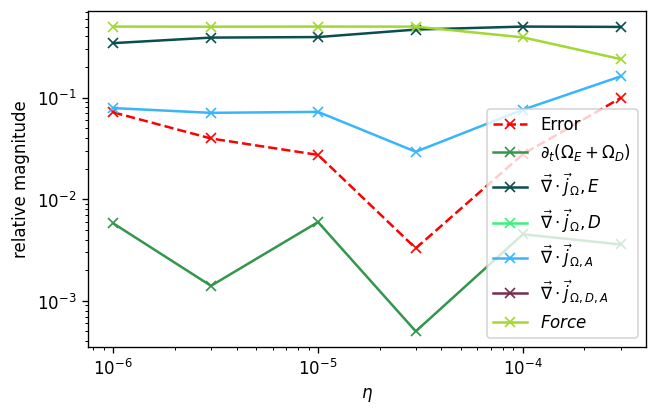

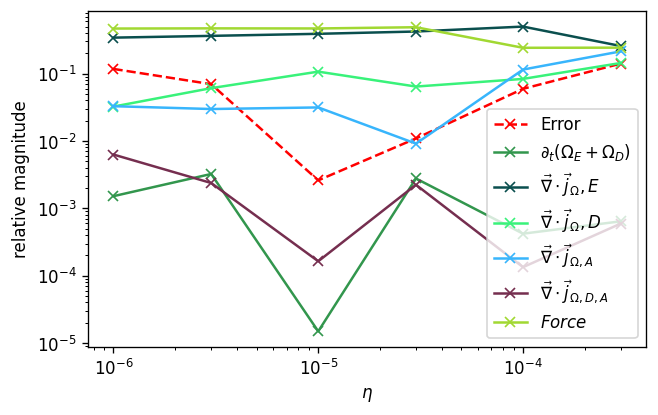

In [32]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_vorticity,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

In [33]:
### THE TERMS IN THE VORTICITY/DENSITY DIFF CONSERVATION
to_plot_mass_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs","ions_ifs_lcfs"], "derive" : True, "signs" : [+1,-1],
        "color": 0,
        "label" : r"$\partial_t n_e-N_i$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec j_E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneC_tt_ifs_lcfs','jvniC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 2,
        "label" : r"$\vec \nabla\cdot\vec j_C$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divjnepar_tt_ifs_lcfs','divjnipar_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 3,
        "label" : r"$\vec \nabla\cdot\vec j_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sne_tt_ifs_lcfs','sni_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 4,
        "label" : r"$S$",
        "vals": {0:dict(),1:dict()},
    },

    ]
}
make_to_plot(to_plot_mass_diff)


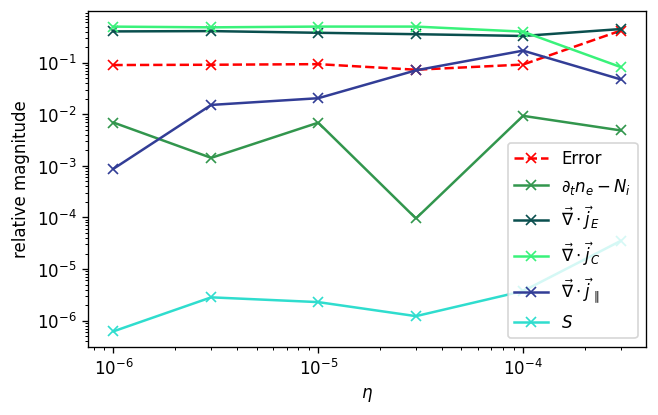

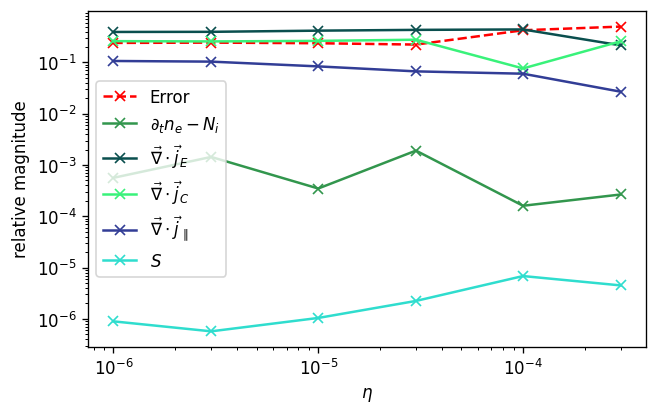

In [34]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

## Ion toroidal momentum plot

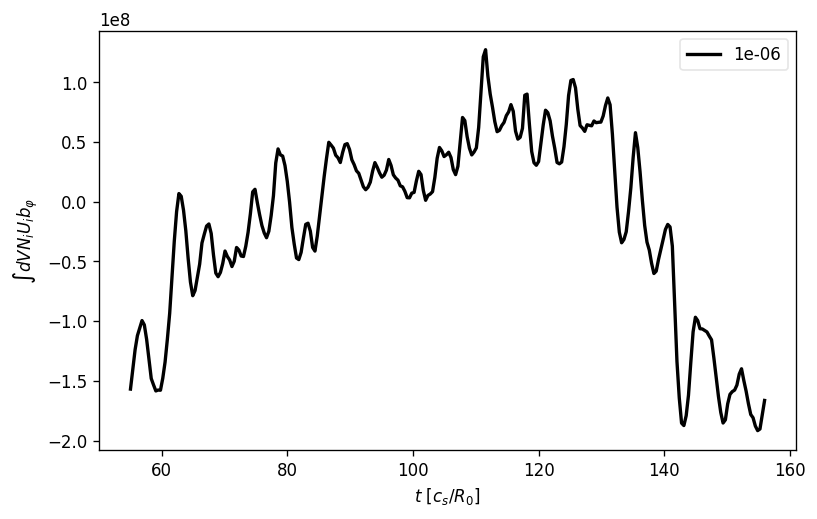

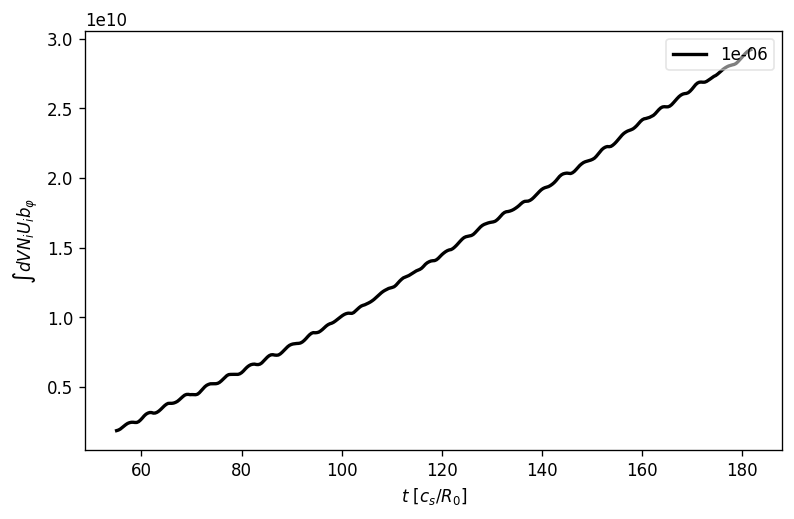

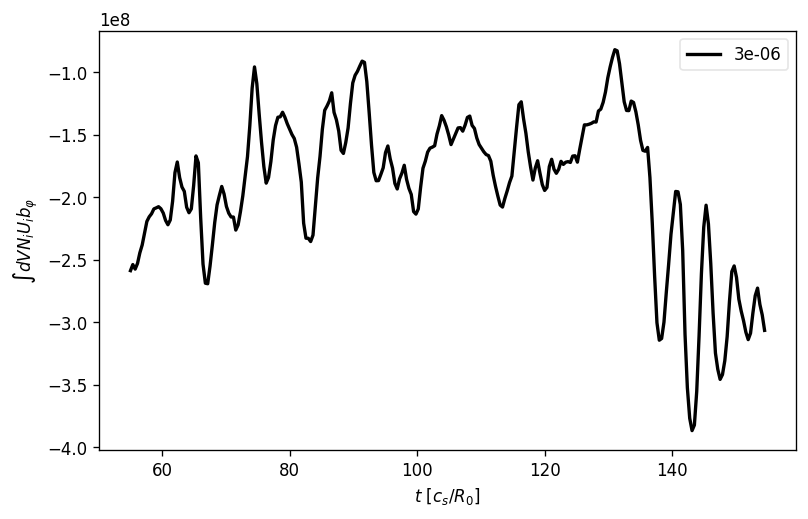

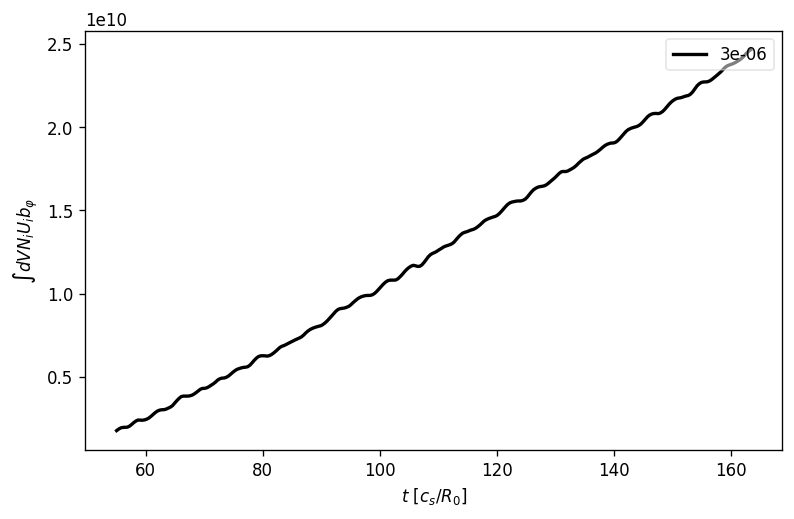

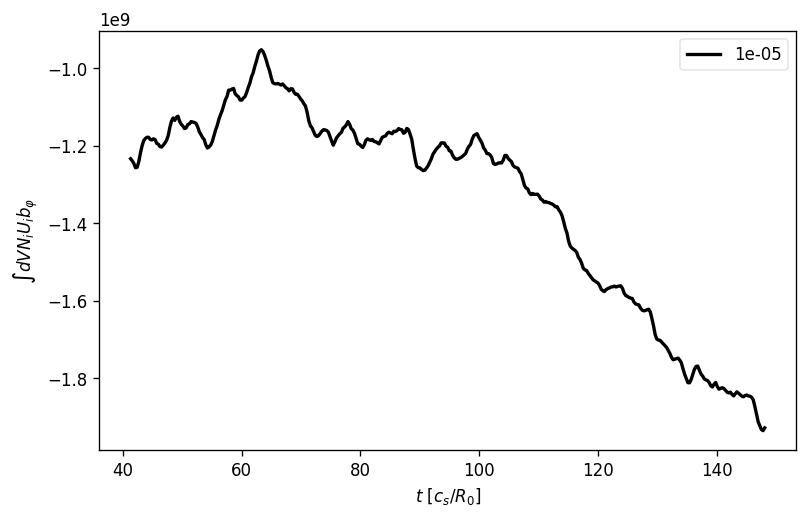

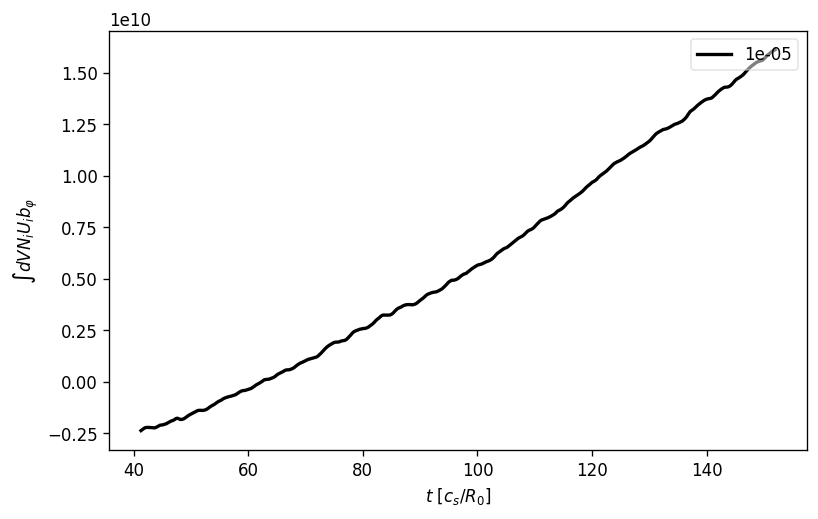

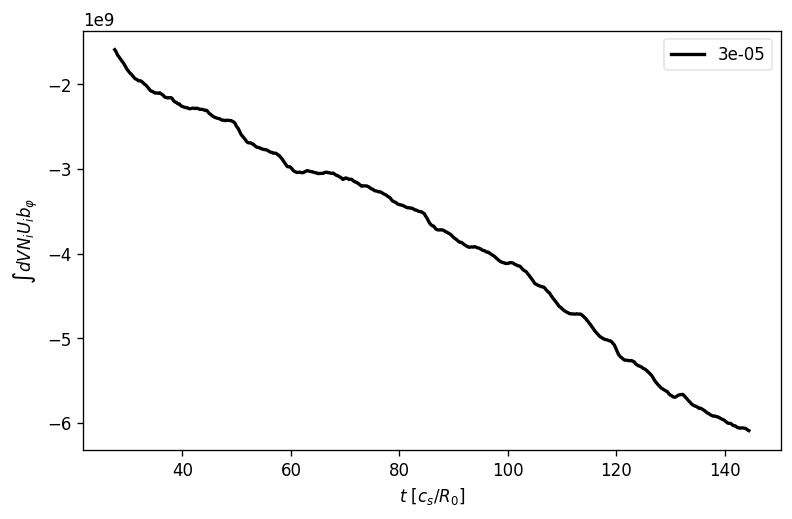

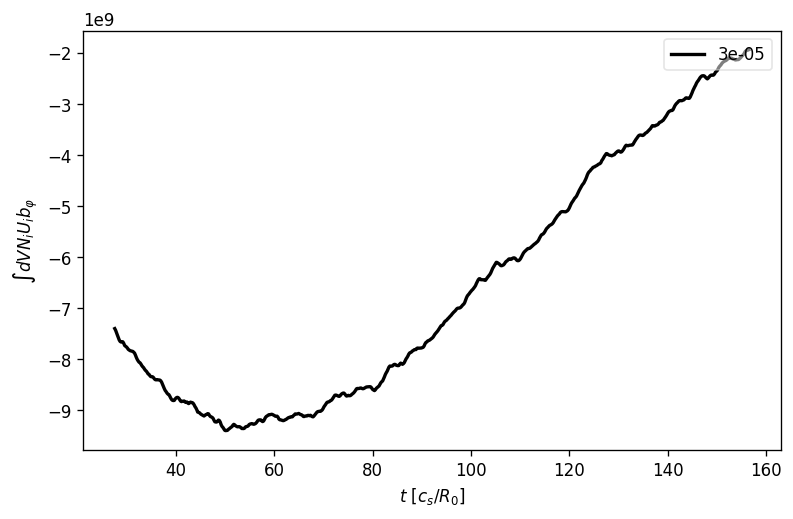

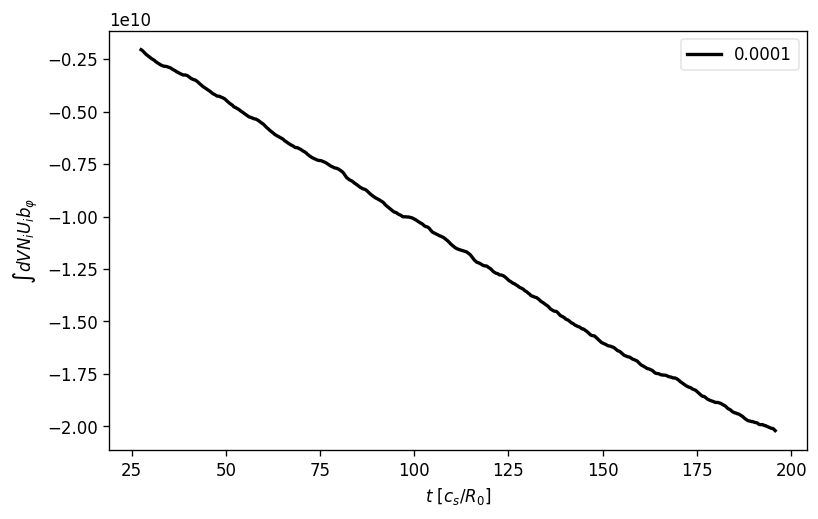

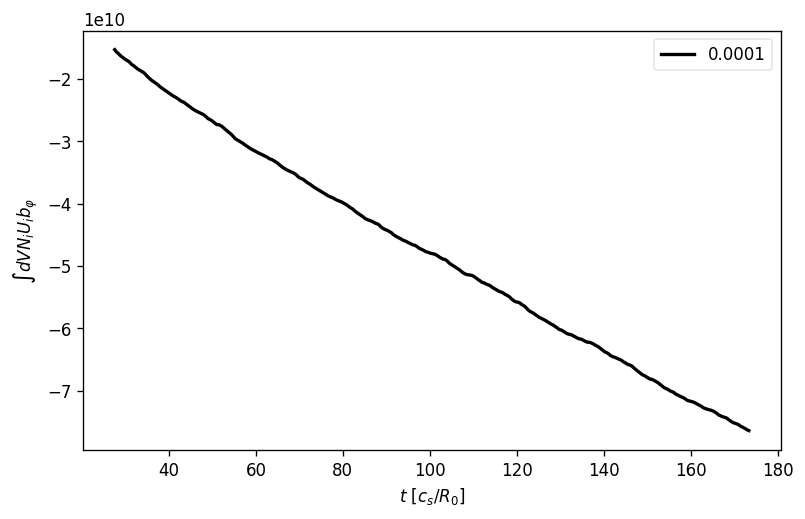

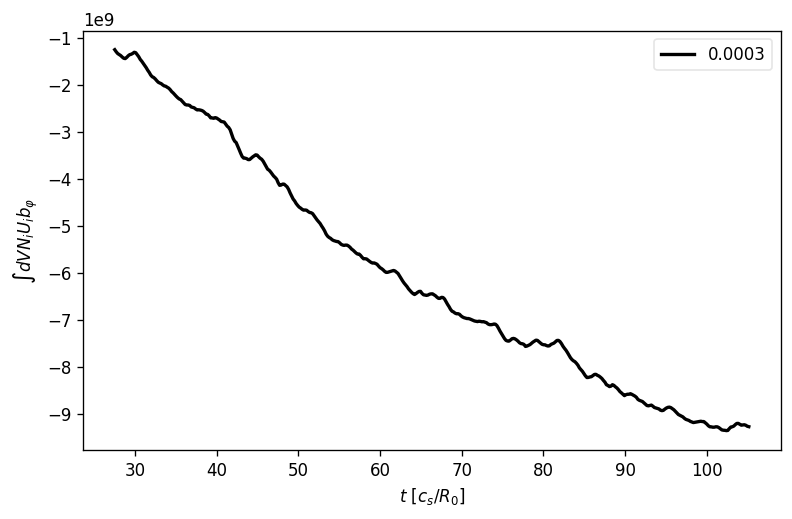

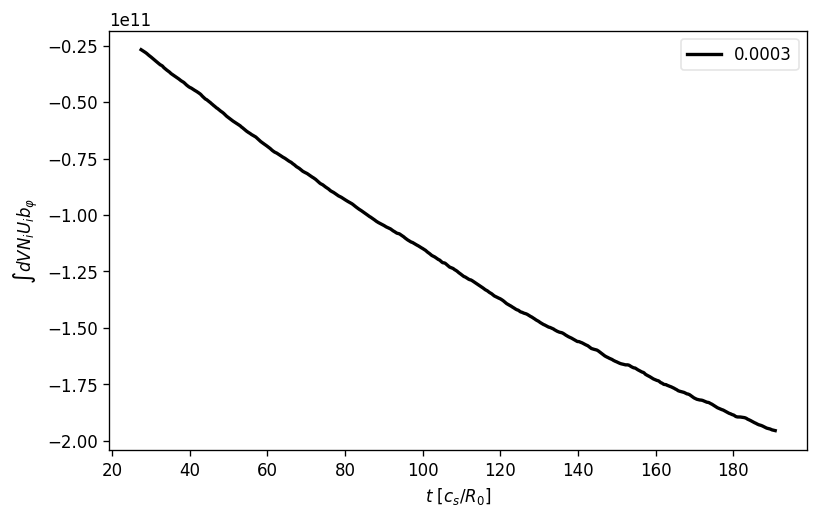

In [35]:
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]*timescale
    
    niuibphi = da.variables['niuibphi_ifs_lcfs'][:]
    oexb = da.variables['oexbi_ifs_lcfs'][:]

    plt.plot(time[min_idx:],niuibphi[min_idx:], color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
#     plt.plot(time[min_idx:],oexb[min_idx:], color='g', 
#          marker='',ls='-', lw=2,markeredgecolor='k', markersize=8
#          )
#     plt.plot(time[min_idx:],niuibphi[min_idx:]-oexb[min_idx:], color='r', 
#          marker='',ls='-', lw=2,markeredgecolor='r', markersize=8
#          )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV  N_iU_ib_\varphi$")

    plt.show(   )

### Ion toroidal momentum accuracy

Resistivity = 1e-06
Average diff =  -113664.97842648251


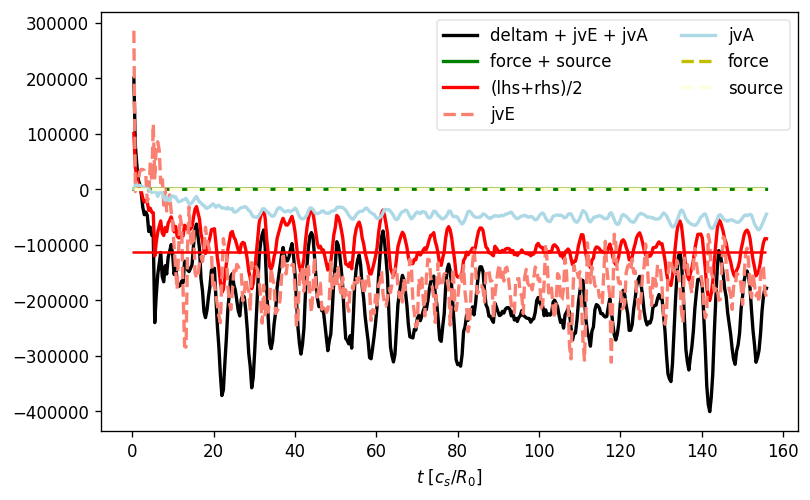

Resistivity = 1e-06
Average diff =  39575.459969873395


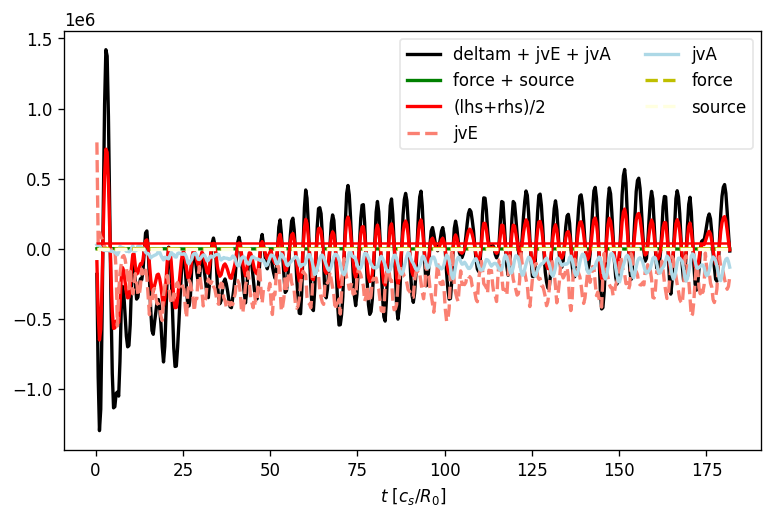

Resistivity = 3e-06
Average diff =  -129070.39504918017


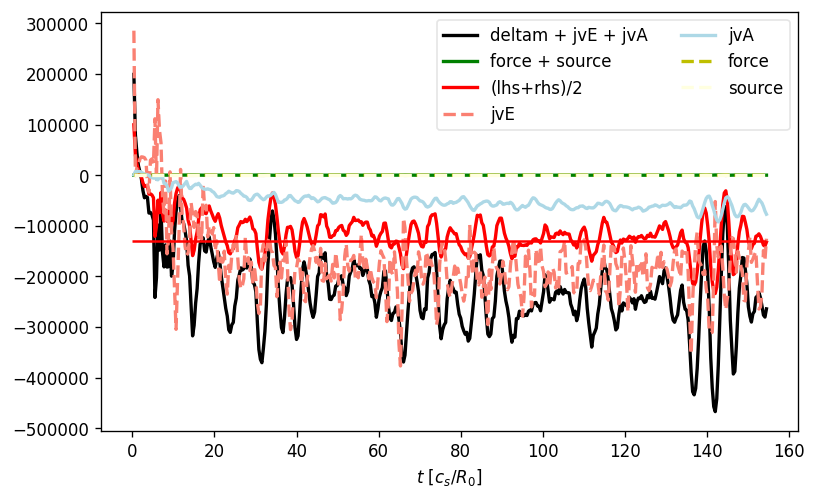

Resistivity = 3e-06
Average diff =  -3677.4861573354015


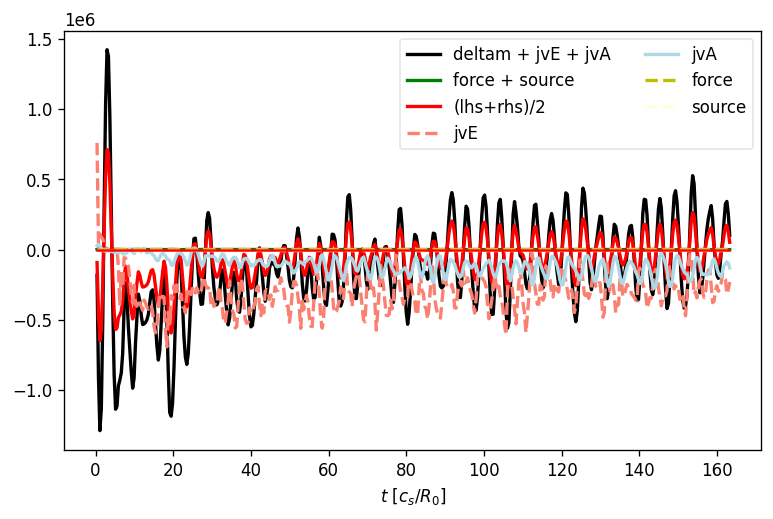

Resistivity = 1e-05
Average diff =  -148307.79649932412


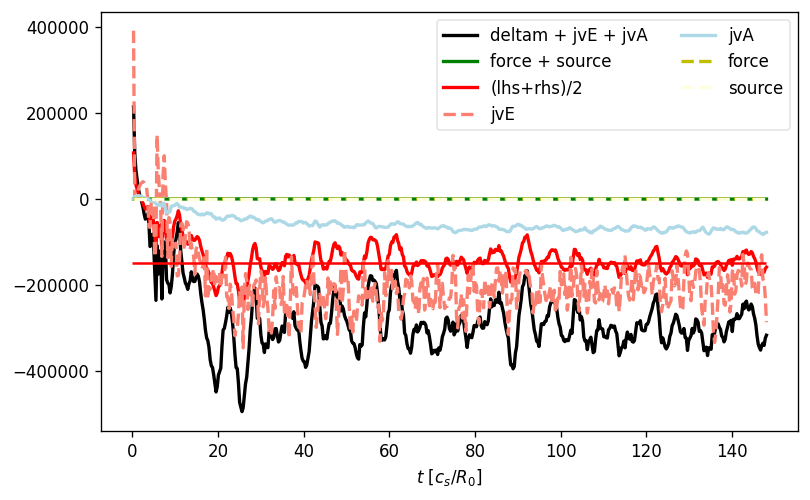

Resistivity = 1e-05
Average diff =  -125913.71307121112


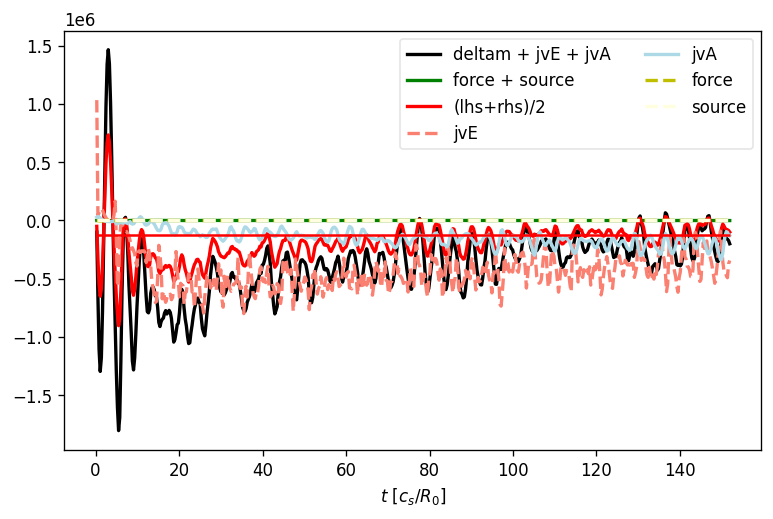

Resistivity = 3e-05
Average diff =  -185939.40253672903


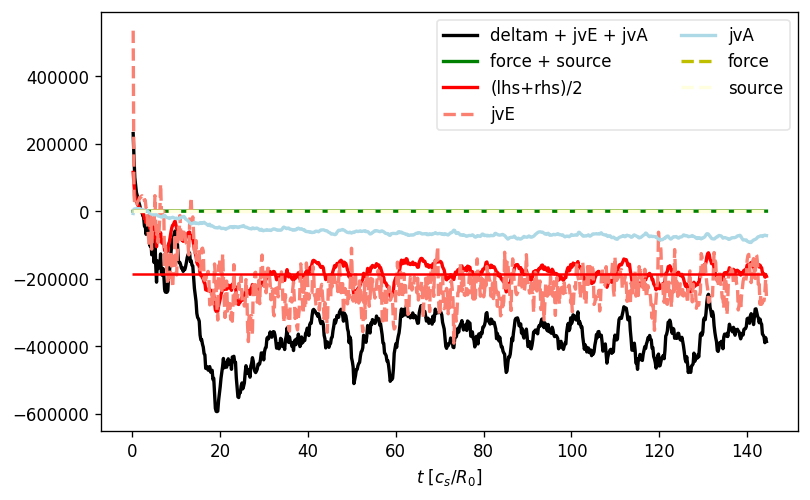

Resistivity = 3e-05
Average diff =  -333726.5582844564


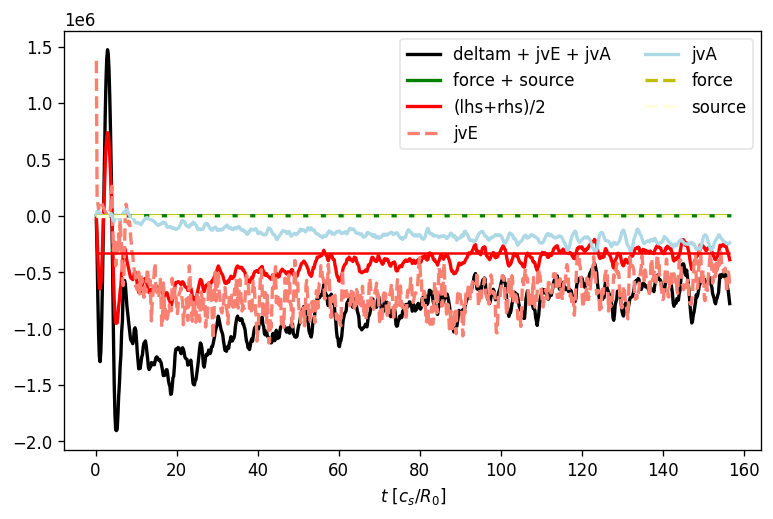

Resistivity = 0.0001
Average diff =  -294982.93579150527


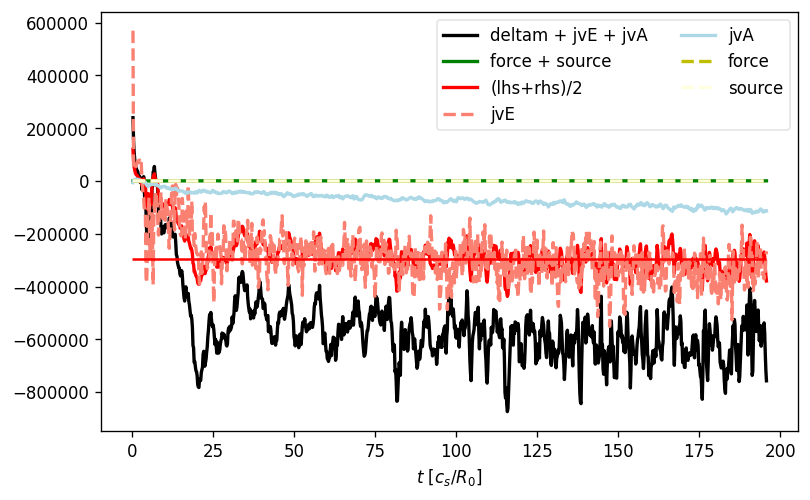

Resistivity = 0.0001
Average diff =  -1087344.8375430792


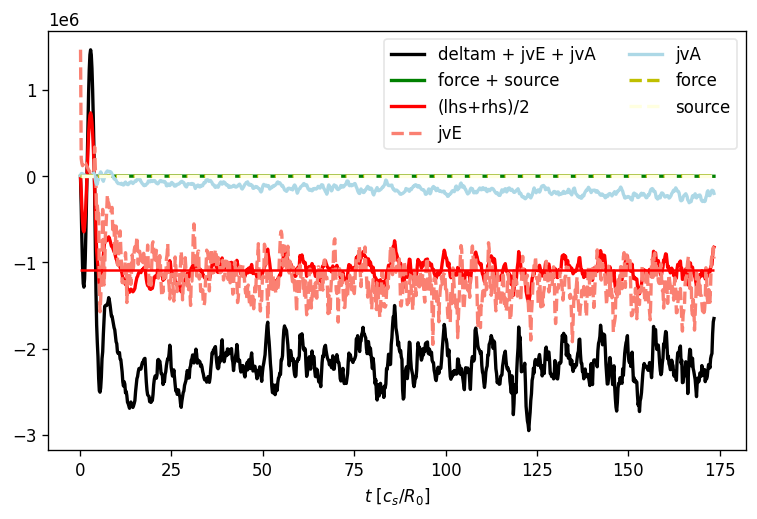

Resistivity = 0.0003
Average diff =  -337469.6463677352


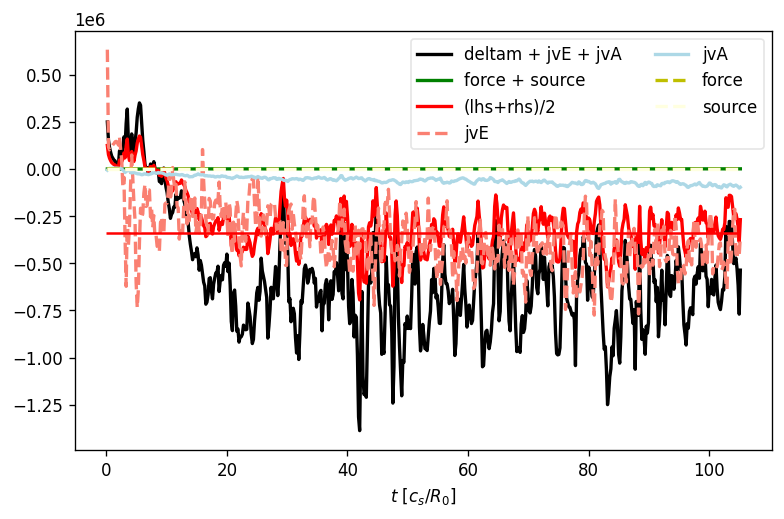

Resistivity = 0.0003
Average diff =  -1875755.4267172376


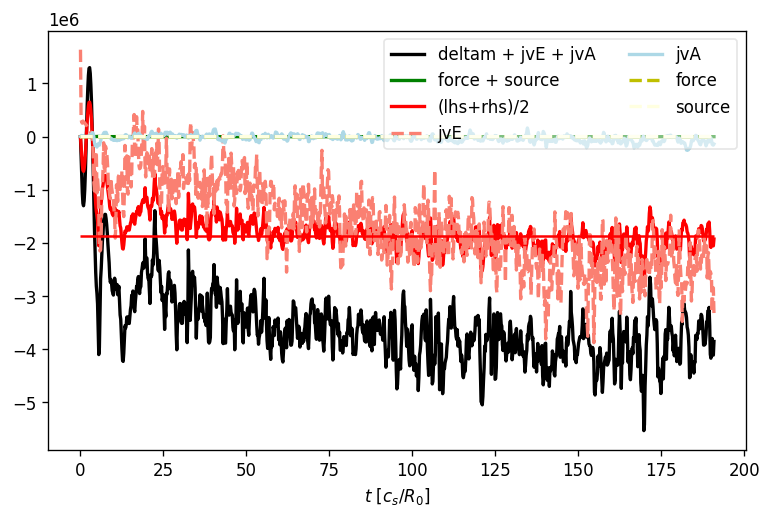

In [36]:
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    
#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    
    
    mass =np.asarray(da.variables['niuibphi_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltam = np.diff(masstt,axis=0)/deltat

    source = np.asarray(da.variables['sparsnibphi_tt_ifs_lcfs'][:])/deltat
    
    jvneE = np.asarray(da['jvparbphiexbi_tt_ifs_lcfs'][:])/deltat
    jvneA = np.asarray(da['jvparbphiApar_tt_ifs_lcfs'][:])/deltat
    
    force = -np.asarray(da.variables["socurve_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvi_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvkappae_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvkappai_tt_ifs_lcfs"][:])/deltat
    lhs = deltam + jvneE + jvneA
    rhs = -force + source
    diff = (lhs - rhs)/2
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="deltam + jvE + jvA")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="force + source")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.plot(time[1:]*timescale,jvneE[1:], color='salmon', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvE")
    plt.plot(time[1:]*timescale,jvneA[1:], color='lightblue', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvA")
    plt.plot(time[1:]*timescale,force[1:], color='y', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
    plt.plot(time[1:]*timescale,source[1:], color='lightyellow', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="source")
    plt.hlines(average_diff, time[0]*timescale, time[-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Ion parallel momentum

In [37]:
### THE TERMS IN THE TOROIDAL MOMENTUM
to_plot_momentum = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ["niui_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_iU_{\parallel,i}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparexbi_tt_ifs_lcfs','jvparApar_tt_ifs_lcfs',
                   'jvpardiai_tt_ifs_lcfs','jvparkappai_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1,1,1,1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec (j_E+j_A)$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ["sparmirrore_tt_ifs_lcfs","sparmirrori_tt_ifs_lcfs"],
        "derive" : False, "signs" : [-1,-1],
        "color": 2,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
#     divjpar = np.asarray(da['divjpare_tt_ifs_lcfs'][:])/deltat
#     divjpar += np.asarray(da['divjpari_tt_ifs_lcfs'][:])/deltat
#     { # is zero
#         "names" : ['sparsni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : False, "signs" : [-2],
        "color": 7,
        "label" : r"$Mirror_A$",
        "vals": {0:dict(),1:dict()},
    },]
}
make_to_plot(to_plot_momentum)


Mean error is  132.52084179776787  std error is  123.77136097217104


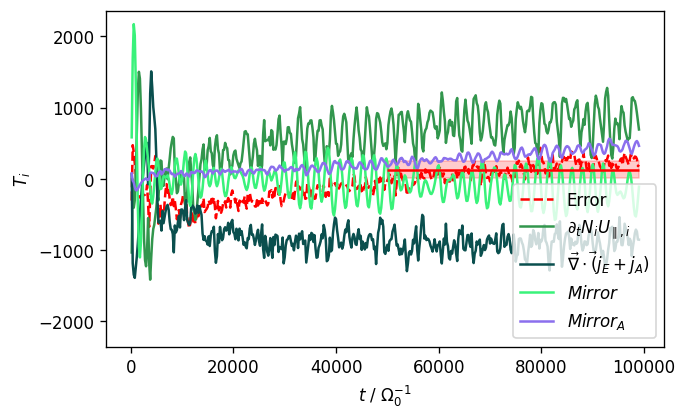

In [38]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-6
if tau == 0:
    to_plot_momentum["fields"][-1]["signs"] = [-1]
if tau == 1:
    to_plot_momentum["fields"][-1]["signs"] = [-2]
plot_series(to_plot_momentum,ax,tau,res)
low, high = ax.get_ylim()
bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

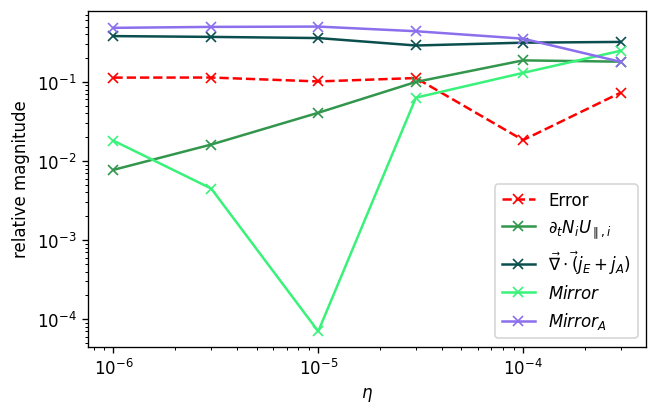

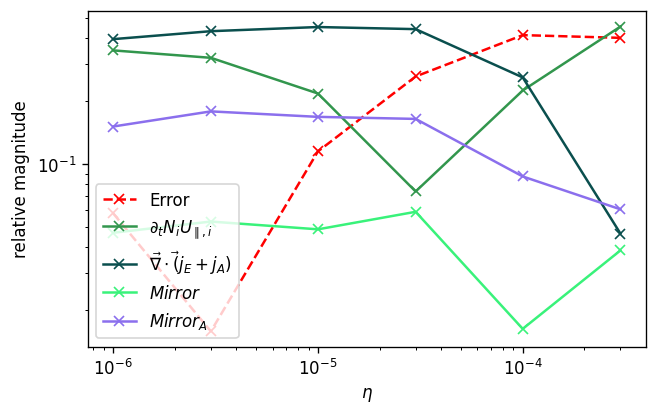

In [39]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    if tau == 0:
        to_plot_momentum["fields"][-1]["signs"] = [-1]
    if tau == 1:
        to_plot_momentum["fields"][-1]["signs"] = [-2]
    plot_relative(to_plot_momentum,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

## Parallel electron force balance

In [40]:
### THE TERMS IN THE PARALLEL ELECTRON FORCE BALANCE
to_plot_electron_force = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ['sparmirrore_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec (j_E+j_A)$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['friction_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 2,
        "label" : r"$\eta$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphie_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 3,
        "label" : r"$n_e\nabla_\parallel\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphiAe_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 4,
        "label" : r"$n_e\nabla_{A,\parallel}\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAe_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 8,
        "label" : r"$n_e\dot A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 7,
        "label" : r"$Mirror_A$",
        "vals": {0:dict(),1:dict()},
    },]
}
make_to_plot(to_plot_electron_force)


Mean error is  -143.92823629500285  std error is  23.373700150759127


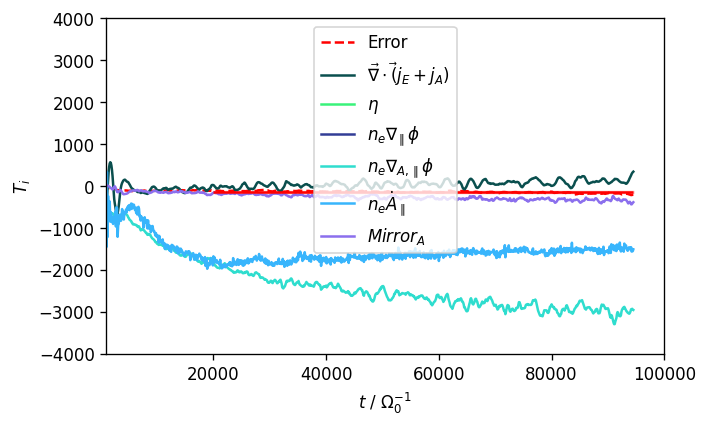

In [41]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_electron_force,ax,tau,res)
low, high = ax.get_ylim()
bound = 4000# max(abs(low), abs(high))
ax.set_ylim(-bound, bound)
ax.set_xlim(1000,100000)
plt.legend()
plt.show()

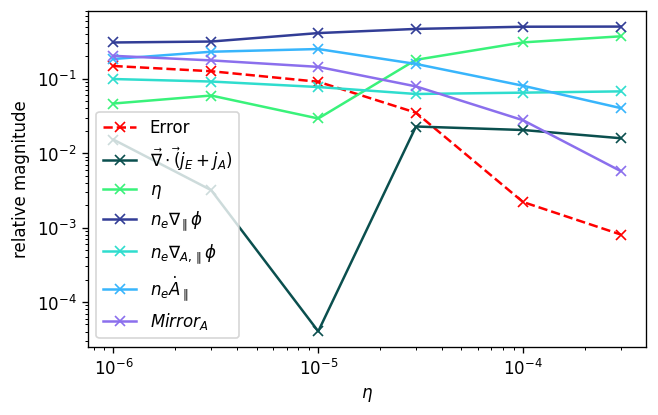

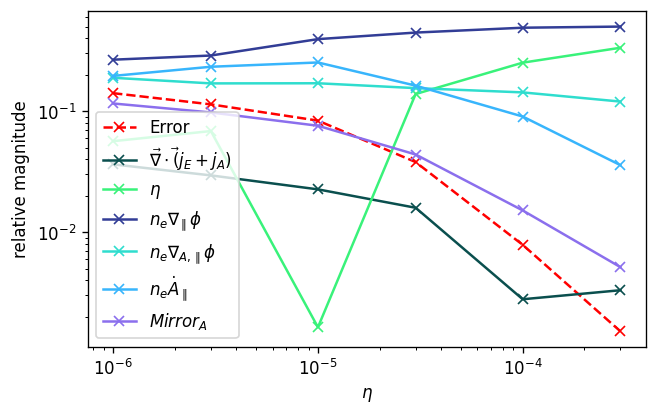

In [42]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    if tau == 0:
        to_plot_momentum["fields"][-1]["signs"] = [-1]
    if tau == 1:
        to_plot_momentum["fields"][-1]["signs"] = [-2]
    plot_relative(to_plot_electron_force,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()